In [101]:
%autosave 180

Autosaving every 180 seconds


In [102]:
#import convex as cx
import requests
import time
import itertools
import numpy
from pprint import pprint
import time
import json
import os
import networkx as nx
from math import sqrt
import spacy
from hdt import HDTDocument

In [103]:
hdt_wd = HDTDocument("data/kb/wikidata2018_09_11.hdt")

In [104]:
#nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("/data/users/romain.claret/tm/wiki-kb-linked-entities/nlp_custom_6")
print(nlp.pipeline)

[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7f450f284910>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7f450f1119f0>), ('ner', <spacy.pipeline.pipes.EntityRecognizer object at 0x7f450f111a60>), ('entity_linker', <spacy.pipeline.pipes.EntityLinker object at 0x7f451093ab10>)]


In [105]:
# load settings
with open( "settings-tmqa-1.json", "r") as settings_data:
    settings = json.load(settings_data)
    use_cache = settings['use_cache']
    save_cache = settings['save_cache']
    cache_path = settings['cache_path']
#cache_path

In [106]:
def save_cache_data():
    if save_cache:
        with open(os.path.join(cache_path,'statements_dict.json'), 'wb') as outfile:
            outfile.write(json.dumps(statements_dict, separators=(',',':')).encode('utf8'))
        with open(os.path.join(cache_path,'wd_labels_dict.json'), 'wb') as outfile:
            outfile.write(json.dumps(wd_labels_dict, separators=(',',':')).encode('utf8'))
        with open(os.path.join(cache_path,'wd_word_ids_dict.json'), 'wb') as outfile:
            outfile.write(json.dumps(wd_word_ids_dict, separators=(',',':')).encode('utf8'))
        with open(os.path.join(cache_path,'wd_predicate_ids_dict.json'), 'wb') as outfile:
            outfile.write(json.dumps(wd_predicate_ids_dict, separators=(',',':')).encode('utf8'))

In [107]:
# Load statements cache
use_cache = False
if use_cache:
    path_statements_dict = "statements_dict.json"
    path_wd_labels_dict = 'wd_labels_dict.json'
    path_wd_word_ids_dict = 'wd_word_ids_dict.json'
    path_wd_predicate_ids_dict = 'wd_predicate_ids_dict.json'
else:
    path_statements_dict = "statements_dict_empty.json"
    path_wd_labels_dict = 'wd_labels_dict_empty.json'
    path_wd_word_ids_dict = 'wd_word_ids_dict_empty.json'
    path_wd_predicate_ids_dict = 'wd_predicate_ids_dict_empty.json'

with open(os.path.join(cache_path,path_statements_dict), "rb") as data:
    statements_dict = json.load(data)
with open(os.path.join(cache_path,path_wd_labels_dict), "rb") as data:
    wd_labels_dict = json.load(data)
with open(os.path.join(cache_path,path_wd_word_ids_dict), "rb") as data:
    wd_word_ids_dict = json.load(data)
with open(os.path.join(cache_path,path_wd_predicate_ids_dict), "rb") as data:
    wd_predicate_ids_dict = json.load(data)

print("len(statements_dict)",len(statements_dict))
print("len(wd_labels_dict)",len(wd_labels_dict))
print("len(wd_word_ids_dict)",len(wd_word_ids_dict))
print("len(wd_predicate_ids_dict)",len(wd_predicate_ids_dict))

len(statements_dict) 0
len(wd_labels_dict) 0
len(wd_word_ids_dict) 0
len(wd_predicate_ids_dict) 0


In [108]:
def get_kb_ents(text):
    #doc = nlp_kb(text)
    doc = nlp(text)
    #for ent in doc.ents:
    #    print(" ".join(["ent", ent.text, ent.label_, ent.kb_id_]))
    return doc.ents
        
ent_text_test = (
    "In The Hitchhiker's Guide to the Galaxy, written by Douglas Adams, "
    "Douglas reminds us to always bring our towel, even in China or Brazil. "
    "The main character in Doug's novel is the man Arthur Dent, "
    "but Dougledydoug doesn't write about George Washington or Homer Simpson."
)

en_text_test_2 = ("Which actor voiced the Unicorn in The Last Unicorn?")

print([ent.kb_id_ for ent in get_kb_ents(ent_text_test)])
#[ent.kb_id_ for ent in get_kb_ents(en_text_test_2)]

['Q42', 'Q18569', 'Q148', 'Q155', 'Q2426198', 'Q613901', 'NIL', 'Q23', 'Q7810']


In [109]:
def get_nlp(sentence):
    return nlp(sentence)

In [110]:
questions = [ 
    "Which actor voiced the Unicorn in The Last Unicorn?",
    "And Alan Arkin was behind...?",
    "And Alan Arkin be behind...? Why How when which was happy make fun",
    "Who is the composer of the soundtrack?",
    "So who performed the songs?",
    "Genre of this band's music?",
    "By the way, who was the director?"
            ]

q_test = str("Which actor voiced the Unicorn in The Last Unicorn? "+
    "And Alan Arkin was behind...? "+
    "And Alan Arkin be behind...? Why How when which was happy make fun. "+
    "Who is the composer of the soundtrack? "+
    "So who performed songs? "+
    "Genre of this band's music? "+
    "By the way, who was the director? ")

q_test_2 = "Who is the wife of Barack Obama?"

In [111]:
q0_nlp = get_nlp(questions[0])
q0_nlp_test = get_nlp(q_test)
q0_nlp_test_2 = get_nlp(q_test_2)
print(q0_nlp)

Which actor voiced the Unicorn in The Last Unicorn?


In [1447]:
import re
def is_wd_entity(to_check):
    pattern = re.compile('^Q[0-9]*$')
    if pattern.match(to_check.strip()): return True
    else: return False

def is_wd_predicate(to_check):
    pattern = re.compile('^P[0-9]*$')
    if pattern.match(to_check.strip()): return True
    else: return False
    
def is_valide_wd_id(to_check):
    if is_wd_entity(to_check) or is_wd_predicate(to_check): return True
    else: return False

print(is_wd_entity("Q155"))

True


In [113]:
# TODO redo the functions and optimize
# TODO add cache
def is_entity_or_literal(wd_object):
    if is_wd_entity(wd_object.strip()):
        return True
    pattern = re.compile('^[A-Za-z0-9]*$')
    if len(wd_object) == 32 and pattern.match(wd_object.strip()):
        return False
    return True

# return if the given string is a literal or a date
def is_literal_or_date (answer): 
    return not('www.wikidata.org' in answer)

# return if the given string describes a year in the format YYYY
def is_year(year):
    pattern = re.compile('^[0-9][0-9][0-9][0-9]$')
    if not(pattern.match(year.strip())):
        return False
    else:
        return True

# return if the given string is a date
def is_date(date):
    pattern = re.compile('^[0-9]+ [A-z]+ [0-9][0-9][0-9][0-9]$')
    if not(pattern.match(date.strip())):
        return False
    else:
        return True

# return if the given string is a timestamp
def is_timestamp(timestamp):
    pattern = re.compile('^[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]T00:00:00Z')
    if not(pattern.match(timestamp.strip())):
        return False
    else:
        return True

# convert the given month to a number
def convert_month_to_number(month):
    return{
        "january" : "01",
        "february" : "02",
        "march" : "03",
        "april" : "04",
        "may" : "05",
        "june" : "06",
        "july" : "07",
        "august" : "08",
        "september" : "09", 
        "october" : "10",
        "november" : "11",
        "december" : "12"
    }[month.lower()]

# convert a date from the wikidata frontendstyle to timestamp style
def convert_date_to_timestamp (date):	
    sdate = date.split(" ")
    # add the leading zero
    if (len(sdate[0]) < 2):
        sdate[0] = "0" + sdate[0]
    return sdate[2] + '-' + convert_month_to_number(sdate[1]) + '-' + sdate[0] + 'T00:00:00Z'

# convert a year to timestamp style
def convert_year_to_timestamp(year):
    return year + '-01-01T00:00:00Z'

# get the wikidata id of a wikidata url
def wikidata_url_to_wikidata_id(url):
    if not url:
        return False
    if "XMLSchema#dateTime" in url or "XMLSchema#decimal" in url:
        date = url.split("\"", 2)[1]
        date = date.replace("+", "")
        return date
    if(is_literal_or_date(url)):
        if is_year(url):
            return convert_year_to_timestamp(url)
        if is_date(url):
            return convert_date_to_timestamp(url)
        else:
            url = url.replace("\"", "")
            return url
    else:
        url_array = url.split('/')
        # the wikidata id is always in the last component of the id
        return url_array[len(url_array)-1]
    
# fetch all statements where the given qualifier statement occurs as subject
def get_all_statements_with_qualifier_as_subject(qualifier):
    statements = []
    triples, cardinality = hdt_wd.search_triples(qualifier, "", "")
    for triple in triples:
        sub, pre, obj = triple
        # only consider triples with a wikidata-predicate
        if pre.startswith("http://www.wikidata.org/"):
            statements.append({'entity': sub, 'predicate': pre, 'object': obj})
    return statements

# fetch the statement where the given qualifier statement occurs as object
def get_statement_with_qualifier_as_object(qualifier):
    triples, cardinality = hdt_wd.search_triples("", "", qualifier)
    for triple in triples:
        sub, pre, obj = triple
        # only consider triples with a wikidata-predicate
        if pre.startswith("http://www.wikidata.org/") and sub.startswith("http://www.wikidata.org/entity/Q"):
            return (sub, pre, obj)
    return False

# returns all statements that involve the given entity
def get_all_statements_of_entity(entity_id):
    # check entity pattern
    if not is_wd_entity(entity_id.strip()):
        return False
    if statements_dict.get(entity_id) != None:
        #print("saved statement")
        return statements_dict[entity_id]
    entity = "http://www.wikidata.org/entity/"+entity_id
    statements = []
    # entity as subject
    triples_sub, cardinality_sub = hdt_wd.search_triples(entity, "", "")
    # entity as object
    triples_obj, cardinality_obj = hdt_wd.search_triples("", "", entity)
    if cardinality_sub + cardinality_obj > 5000:
        statements_dict[entity_id] = []
        return []
    # iterate through all triples in which the entity occurs as the subject
    for triple in triples_sub:
        sub, pre, obj = triple
        # only consider triples with a wikidata-predicate or if it is an identifier predicate
        if not pre.startswith("http://www.wikidata.org/"):# or (wikidata_url_to_wikidata_id(pre) in identifier_predicates):
            continue
        # object is statement
        if obj.startswith("http://www.wikidata.org/entity/statement/"):
            qualifier_statements = get_all_statements_with_qualifier_as_subject(obj)
            qualifiers = []
            for qualifier_statement in qualifier_statements:
                if qualifier_statement['predicate'] == "http://www.wikidata.org/prop/statement/" + wikidata_url_to_wikidata_id(pre):
                        obj = qualifier_statement['object']
                elif is_entity_or_literal(wikidata_url_to_wikidata_id(qualifier_statement['object'])):
                    qualifiers.append({
                        "qualifier_predicate":{
                            "id": wikidata_url_to_wikidata_id(qualifier_statement['predicate'])
                        }, 
                        "qualifier_object":{	
                            "id": wikidata_url_to_wikidata_id(qualifier_statement['object'])
                        }})
            statements.append({'entity': {'id': wikidata_url_to_wikidata_id(sub)}, 'predicate': {'id': wikidata_url_to_wikidata_id(pre)}, 'object': {'id': wikidata_url_to_wikidata_id(obj)}, 'qualifiers': qualifiers})
        else:
            statements.append({'entity': {'id': wikidata_url_to_wikidata_id(sub)}, 'predicate': {'id': wikidata_url_to_wikidata_id(pre)}, 'object': {'id': wikidata_url_to_wikidata_id(obj)}, 'qualifiers': []})
    # iterate through all triples in which the entity occurs as the object
    for triple in triples_obj:
        sub, pre, obj = triple
        # only consider triples with an entity as subject and a wikidata-predicate or if it is an identifier predicate
        if not sub.startswith("http://www.wikidata.org/entity/Q"):# or not pre.startswith("http://www.wikidata.org/") or wikidata_url_to_wikidata_id(pre) in identifier_predicates:
            continue
        if sub.startswith("http://www.wikidata.org/entity/statement/"):
            statements_with_qualifier_as_object =  get_statement_with_qualifier_as_object(sub, process)
            # if no statement was found continue
            if not statements_with_qualifier_as_object:
                continue
            main_sub, main_pred, main_obj = statements_with_qualifier_as_object
            qualifier_statements = get_all_statements_with_qualifier_as_subject(sub)
            qualifiers = []
            for qualifier_statement in qualifier_statements:
                if wikidata_url_to_wikidata_id(qualifier_statement['predicate']) == wikidata_url_to_wikidata_id(main_pred):
                    main_obj = qualifier_statement['object']
                elif is_entity_or_literal(wikidata_url_to_wikidata_id(qualifier_statement['object'])):
                    qualifiers.append({
                        "qualifier_predicate":{"id": wikidata_url_to_wikidata_id(qualifier_statement['predicate'])}, 
                        "qualifier_object":{"id": wikidata_url_to_wikidata_id(qualifier_statement['object'])}
                    })
            statements.append({
                            'entity': {'id': wikidata_url_to_wikidata_id(main_sub)},
                            'predicate': {'id': wikidata_url_to_wikidata_id(main_pred)},
                            'object': {'id': wikidata_url_to_wikidata_id(main_obj)},
                            'qualifiers': qualifiers
                              })
        else:
            statements.append({'entity': {'id': wikidata_url_to_wikidata_id(sub)}, 'predicate': {'id': wikidata_url_to_wikidata_id(pre)}, 'object': {'id': wikidata_url_to_wikidata_id(obj)}, 'qualifiers': []})
    # cache the data
    statements_dict[entity_id] = statements
    return statements

print(len(get_all_statements_of_entity("Q16614390")))
#save_cache_data()

12


In [114]:
def get_wd_ids_online(name, is_predicate=False, top_k=3):
    name = name.split('(')[0]
    
    if is_predicate and wd_predicate_ids_dict.get(name) != None:
        #print("saved predicate online")
        return wd_predicate_ids_dict[name]
    elif not is_predicate and wd_word_ids_dict.get(name) != None:
        #print("saved word online")
        return wd_word_ids_dict[name]

    request_successfull = False
    entity_ids = ""
    while not request_successfull:
        try:
            if is_predicate:
                entity_ids = requests.get('https://www.wikidata.org/w/api.php?action=wbsearchentities&format=json&language=en&type=property&limit=' + str(top_k) + '&search='+name).json()
            else:
                entity_ids = requests.get('https://www.wikidata.org/w/api.php?action=wbsearchentities&format=json&language=en&limit=' + str(top_k) + '&search='+name).json()
            request_successfull = True
        except:
            time.sleep(5)
    results = entity_ids.get("search")
    if not results:
        if is_predicate: wd_predicate_ids_dict[name] = ""
        else: wd_word_ids_dict[name] = ""
        return ""
    if not len(results):
        if is_predicate: wd_predicate_ids_dict[name] = ""
        else: wd_word_ids_dict[name] = ""
        return ""
    res = []
    for result in results:
        res.append(result['id'])
    
    if is_predicate: wd_predicate_ids_dict[name] = res
    else: wd_word_ids_dict[name] = res
    
    return res
print(get_wd_ids_online("voiced", is_predicate=False, top_k=1))

['Q7907375']


In [115]:
import warnings
warnings.filterwarnings('ignore')

# very computational
def get_most_similar(word, topn=5):
  word = nlp.vocab[str(word)]
  queries = [w for w in word.vocab if w.is_lower == word.is_lower and w.prob >= -15]
  by_similarity = sorted(queries, key=lambda w: word.similarity(w), reverse=True)
  return [(w.lower_,w.similarity(word)) for w in by_similarity[:topn+1] if w.lower_ != word.lower_]

print(get_most_similar("voiced", topn=3))

[('voicing', 0.7561705), ('voices', 0.6340212), ('voice', 0.5594842)]


In [116]:
def get_wd_ids(word, is_predicate=False, top_k=3, limit=10):
    if is_predicate and wd_predicate_ids_dict.get(word) != None:
        #print("saved predicate local")
        return wd_predicate_ids_dict[word]
    elif not is_predicate and wd_word_ids_dict.get(word) != None:
        #print("saved word local")
        return wd_word_ids_dict[word]
    
    language = "en"
    word_formated = str("\""+word+"\""+"@"+language)
    to_remove = len("http://www.wikidata.org/entity/")
    t_name, card_name = hdt_wd.search_triples("", "http://schema.org/name", word_formated, limit=top_k)
    #print("names cardinality of \"" + word+"\": %i" % card_name)
    t_alt, card_alt = hdt_wd.search_triples("", 'http://www.w3.org/2004/02/skos/core#altLabel', word_formated, limit=top_k)
    #print("alternative names cardinality of \"" + word+"\": %i" % card_alt)
    results = list(set(
        [t[0][to_remove:] for t in t_name if is_valide_wd_id(t[0][to_remove:])] + 
        [t[0][to_remove:] for t in t_alt if is_valide_wd_id(t[0][to_remove:])]
           ))
    
    if is_predicate: results = [r for r in results if is_wd_predicate(r)]
        
    # cache the data
    if is_predicate: wd_predicate_ids_dict[word] = results
    else: wd_word_ids_dict[word] = results
    
    return results if limit<=0 else results[:limit]
     
    
#get_wd_ids("The Last Unicorn", top_k=0, limit=10)
print(get_wd_ids("wife", is_predicate=False , top_k=0, limit=0))
#print(get_wd_ids("voiced", is_predicate=False , top_k=0, limit=0))

['P26', 'Q24039104', 'Q188830']


In [117]:
def get_wd_label(from_id):
    #print("from_id",from_id)
    if is_valide_wd_id(from_id):
        if wd_labels_dict.get(from_id) != None:
            #print("saved label local")
            return wd_labels_dict[from_id]
        
        language = "en"
        id_url = "http://www.wikidata.org/entity/"+from_id
        t_name, card_name = hdt_wd.search_triples(id_url, "http://schema.org/name", "")
        name = [t[2].split('\"@en')[0].replace("\"", "") for t in t_name if "@"+language in t[2]]
        result = name[0] if name else ''
        wd_labels_dict[from_id] = result #caching
        return result
        
    else:
        return ''
    
print(get_wd_label("P725"))
#get_wd_label("Q20789322")

voice actor


In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

# Building colors from graph
def get_color(node_type):
    if node_type == "entity": return "violet"#"cornflowerblue"
    elif node_type == "predicate": return "yellow"
    else: return "red"

# Building labels for graph
def get_elements_from_graph(graph):
    node_names = nx.get_node_attributes(graph,"name")
    node_types = nx.get_node_attributes(graph,"type")
    colors = [get_color(node_types[n]) for n in node_names]
    return node_names, colors

# Plotting the graph
def plot_graph(graph, name, title="Graph"):
    fig = plt.figure(figsize=(14,14))
    ax = plt.subplot(111)
    ax.set_title(str("answer: "+title), fontsize=10)
    #pos = nx.spring_layout(graph)
    labels, colors = get_elements_from_graph(graph)
    nx.draw(graph, node_size=30, node_color=colors, font_size=10, font_weight='bold', with_labels=True, labels=labels)
    plt.tight_layout()
    plt.savefig("tmqa1_graphs_imgs/"+str(name)+".png", format="PNG", dpi = 300)
    plt.show()
    
#plot_graph(graph, "file_name_graph", "Graph_title")

In [119]:
def make_statements_graph(statements, indexing_predicates=True):
    graph = nx.Graph()
    turn=0
    predicate_nodes = {}

    for statement in statements:
        #print(statement)
        if not statement['entity']['id'] in graph:
            graph.add_node(statement['entity']['id'], name=get_wd_label(statement['entity']['id']), type='entity', turn=turn)
        if not statement['object']['id'] in graph:
            graph.add_node(statement['object']['id'], name=get_wd_label(statement['object']['id']), type='entity', turn=turn)

        # increment index of predicate or set it at 0
        if not statement['predicate']['id'] in predicate_nodes or not indexing_predicates:
            predicate_nodes_index = 1
            predicate_nodes[statement['predicate']['id']] = 1
        else:
            predicate_nodes[statement['predicate']['id']] += 1
            predicate_nodes_index = predicate_nodes[statement['predicate']['id']]

        # add the predicate node
        predicate_node_id = (statement['predicate']['id'])
        if indexing_predicates: predicate_node_id += "-" + str(predicate_nodes_index)
        
        graph.add_node(predicate_node_id, name=get_wd_label(statement['predicate']['id']), type='predicate', turn=turn)

        # add the two edges (entity->predicate->object)
        graph.add_edge(statement['entity']['id'], predicate_node_id)
        graph.add_edge(predicate_node_id, statement['object']['id'])
    
    return graph, predicate_nodes

#test_graph = make_statements_graph(test_unduplicate_statements, indexing_predicates=False)
#print(test_graph[1])
#plot_graph(test_graph[0],"test")

In [120]:
def merge_lists(list_1, list_2):
    if len(list_1) == len(list_2):
        return [(list_1[i], list_2[i]) for i in range(0, len(list_1))]
    else:
        return "Error: lists are not the same lenght"

print(merge_lists(["author"],['P50']))



[('author', 'P50')]


In [121]:
def get_themes(nlp_question, top_k=3):
    # PART1: finding themes as the user typed it
    filter_list = ["PART", "PRON"]
    nlp_list = list(nlp_question)
    for i,w in enumerate(nlp_question):
        #print(w.pos_)
        if w.pos_ in filter_list:
            #print(w.pos_)
            del nlp_list[i]
    nlp_question = get_nlp(" ".join([e.text for e in nlp_list]))
    
    themes = [(ent, [ent.kb_id_]) for ent in get_kb_ents(nlp_question.text) if ent.kb_id_ != "NIL"]
    theme_complements = []
    
    noun_chunks = [chunk for chunk in nlp_question.noun_chunks]
    theme_ids = [get_wd_ids(chunk.text, top_k=top_k) for chunk in noun_chunks]

    for i, chunk in enumerate(theme_ids):
        if chunk: themes.append((noun_chunks[i], chunk))
        else: theme_complements.append(noun_chunks[i])
    
    # PART2: finding themes with the question capitalized
    #print(nlp_question)
    nlp_list_cap = []
    nlp_list_low = []
    nlp_list_lemma = []
    nlp_list_no_det = []
    w_filter = ["WDT","WP","WP$","WRB"]
    for w in nlp_question:
        if w.tag_ not in w_filter:
            nlp_list_cap.append(w.text.capitalize())
            nlp_list_low.append(w.text.lower())
            nlp_list_lemma.append(w.lemma_)
        if w.pos_ == "DET":
            nlp_list_no_det.append(w.text)
            
    nlp_question_cap = get_nlp(" ".join([e for e in nlp_list_cap]))
    nlp_question_low = get_nlp(" ".join([e for e in nlp_list_low]))
    nlp_question_lemma = get_nlp(" ".join([e for e in nlp_list_lemma]))
    nlp_question_no_det = get_nlp(" ".join([e for e in nlp_list_no_det]))

    themes += [(ent, [ent.kb_id_]) for ent in get_kb_ents(nlp_question_cap.text) if ent.kb_id_ != "NIL" and (ent, [ent.kb_id_]) not in themes]
    themes += [(ent, [ent.kb_id_]) for ent in get_kb_ents(nlp_question_low.text) if ent.kb_id_ != "NIL" and (ent, [ent.kb_id_]) not in themes]
    themes += [(ent, [ent.kb_id_]) for ent in get_kb_ents(nlp_question_lemma.text) if ent.kb_id_ != "NIL" and (ent, [ent.kb_id_]) not in themes]
    themes += [(ent, [ent.kb_id_]) for ent in get_kb_ents(nlp_question_no_det.text) if ent.kb_id_ != "NIL" and (ent, [ent.kb_id_]) not in themes]
    
    #print(themes)
    
    noun_chunks = [chunk for chunk in nlp_question_cap.noun_chunks]
    theme_ids = [get_wd_ids(chunk.text, top_k=top_k) for chunk in noun_chunks]

    for i, chunk in enumerate(theme_ids):
        if chunk: themes.append((noun_chunks[i], chunk))
        else: theme_complements.append(noun_chunks[i])
    
    noun_chunks = [chunk for chunk in nlp_question_low.noun_chunks]
    theme_ids = [get_wd_ids(chunk.text, top_k=top_k) for chunk in noun_chunks]

    for i, chunk in enumerate(theme_ids):
        if chunk: themes.append((noun_chunks[i], chunk))
        else: theme_complements.append(noun_chunks[i])
            
    noun_chunks = [chunk for chunk in nlp_question_lemma.noun_chunks]
    theme_ids = [get_wd_ids(chunk.text, top_k=top_k) for chunk in noun_chunks]

    for i, chunk in enumerate(theme_ids):
        if chunk: themes.append((noun_chunks[i], chunk))
        else: theme_complements.append(noun_chunks[i])
            
    noun_chunks = [chunk for chunk in nlp_question_no_det.noun_chunks]
    theme_ids = [get_wd_ids(chunk.text, top_k=top_k) for chunk in noun_chunks]

    for i, chunk in enumerate(theme_ids):
        if chunk: themes.append((noun_chunks[i], chunk))
        else: theme_complements.append(noun_chunks[i])
    
    themes_filtered = []
    for t in themes:
        if t[0].text in [tf[0].text for tf in themes_filtered]:
            index = [tf[0].text for tf in themes_filtered].index(t[0].text)
            tmp = t[1]+[i for j in [tf[1] for index, tf in enumerate(themes_filtered) if tf[0].text == t[0].text] for i in j]
            themes_filtered[index] = (t[0],tmp)

        else:
            themes_filtered.append(t)
    #print(themes_filtered)
    return themes_filtered, theme_complements

q0_themes = get_themes(q0_nlp, top_k=3)
#q0_themes_test = get_themes(q0_nlp_test)
#q0_themes_test_2 = get_themes(q0_nlp_test_2)
print(q0_themes)

#q_test_3 = get_nlp("the unicorn and the raccoons love obama barack's tacos")
#q_test_3_themes = get_themes(q_test_3, top_k=3)
#print(get_enhanced_themes(q_test_3_themes))
#print(q_test_3_themes)

([(The Last Unicorn, ['Q15628943', 'Q16614390', 'Q176198', 'Q30060419', 'Q15628943', 'Q16614390', 'Q176198', 'Q30060419']), (The Unicorn, ['Q18647334', 'Q17985004', 'Q17553756', 'Q65070436']), (Unicorn, ['Q7246', 'Q7246']), (Actor, ['Q17521118', 'Q20496310', 'Q24053571', 'Q17521117', 'Q12811724', 'Q11282976']), (actor, ['Q4677712', 'Q33999', 'Q421946', 'P161', 'Q10798782'])], [Which actor, the Unicorn, the unicorn, the last unicorn, the Unicorn, the last Unicorn])


In [1482]:
def get_theme_tuples(theme_list, top_k=3):
    return [(t, get_wd_ids(t, top_k=top_k)) for t in theme_list]

def get_theme_no_stopwords(theme_list):
    return [s for s in theme_list if not s.is_stop]

def get_theme_lemmatized(theme_list):
    return [s.lemma_ for s in theme_list]

def get_permutation_tuples(theme_list, start=2):
    permutations = []
    for i in range(start, len(theme_list)+1):
        permutations += itertools.permutations(theme_list,i)
    return permutations

def get_lemma_permutation_tuples(theme_list, start=2):
    return get_permutation_tuples(get_theme_lemmatized(theme_list), start=2)

def get_non_token_tuples(theme_list):
    return [" ".join([e for e in list(l)]) for l in theme_list]

def get_non_token_lower_tuples(theme_list):
    return [" ".join([e.lower() for e in list(l)]) for l in theme_list]

def get_non_token_capitalize_tuples(theme_list):
    return [" ".join([c.capitalize() for c in [e for e in list(l)]]) for l in theme_list] 

def get_text_tuples(theme_list):
    return [" ".join([e.text for e in list(l)]) for l in theme_list]

def get_lower_tuples(theme_list):
    return [" ".join([e.lower_ for e in list(l)]) for l in theme_list]

def get_capitalized_tuples(theme_list):
    return [" ".join([c.capitalize() for c in [e.text for e in list(l)]]) for l in theme_list]

def get_enhanced_themes(themes, top_k=3):
    enhanced_themes = []
    # permute, capitalize, lowering of the words in the complements
    for c in themes[1]:

        per_lemma = get_theme_tuples(get_non_token_tuples([n for n in get_permutation_tuples(get_theme_lemmatized(c))]),top_k)
        per_nostop = get_theme_tuples(get_text_tuples(get_permutation_tuples(get_theme_no_stopwords(c),start=1)),top_k)
        per_lemma_nostop = get_theme_tuples(get_non_token_tuples([get_theme_lemmatized(s) for s in get_permutation_tuples(get_theme_no_stopwords(c),start=1)]),top_k)
    
        per_lemma_lower = get_theme_tuples(get_non_token_lower_tuples([n for n in get_permutation_tuples(get_theme_lemmatized(c))]),top_k)
        per_nostop_lower = get_theme_tuples(get_lower_tuples(get_permutation_tuples(get_theme_no_stopwords(c),start=1)),top_k)
        per_lemma_nostop_lower = get_theme_tuples(get_non_token_lower_tuples([get_theme_lemmatized(s) for s in get_permutation_tuples(get_theme_no_stopwords(c),start=1)]),top_k)
        
        per_lemma_capitalize = get_theme_tuples(get_non_token_capitalize_tuples([n for n in get_permutation_tuples(get_theme_lemmatized(c))]),top_k)
        per_nostop_capitalize = get_theme_tuples(get_capitalized_tuples(get_permutation_tuples(get_theme_no_stopwords(c),start=1)),top_k)
        per_lemma_nostop_capitalize = get_theme_tuples(get_non_token_capitalize_tuples([get_theme_lemmatized(s) for s in get_permutation_tuples(get_theme_no_stopwords(c),start=1)]),top_k)

        per = get_theme_tuples(get_text_tuples(get_permutation_tuples(c)),top_k)
        per_lower = get_theme_tuples(get_lower_tuples(get_permutation_tuples(c)),top_k)
        per_capitalize = get_theme_tuples(get_capitalized_tuples(get_permutation_tuples(c)),top_k)
        
        for p in (per + per_lower + per_capitalize +
                 per_lemma + per_lemma_lower + per_lemma_capitalize +
                 per_nostop + per_nostop_lower + per_nostop_capitalize +
                 per_lemma_nostop + per_lemma_nostop_lower + per_lemma_nostop_capitalize):
            if p[1] and p not in enhanced_themes: enhanced_themes.append(p)
    
    predicates = []
    [predicates.append(get_wd_label(pred)) for pred in sum([p[1] for p in themes[0]],[]) if get_wd_label(pred) not in predicates]
    predicates_ids = [get_wd_ids_online(p, is_predicate=True, top_k=top_k) for p in predicates]
    predicated_themes = merge_lists(predicates, predicates_ids)
    predicated_themes = [pt for pt in predicated_themes if pt[1] != '']
    
    #print("themes[0]",themes[0])
    #print("predicated_themes",predicated_themes)
    return enhanced_themes#+predicated_themes

#q_test_3 = get_nlp("the unicorn and the raccoons love obama barack's tacos")
q_test_3 = get_nlp("what was the cause of death of yves klein")
q_test_3_themes = get_themes(q_test_3, top_k=3)
print(q_test_3_themes[0])
print(get_enhanced_themes(q_test_3_themes))

[(death, ['P570', 'Q18748141', 'Q4', 'P570', 'Q18748141', 'Q4', 'P570', 'Q18748141', 'Q4']), (The Cause, ['Q15865919', 'Q7721755']), (Death, ['Q16155756', 'Q1403445', 'Q161936', 'Q31508082', 'Q3959565']), (Yves Klein, ['Q154335'])]
[('The Cause', ['Q15865919', 'Q7721755']), ('cause', ['Q12602537', 'P828', 'Q2574811']), ('Cause', ['Q4236411', 'Q37240455', 'Q19027542', 'Q643653']), ('Yves Klein', ['Q154335']), ('Yves', ['Q1220456', 'Q3592802', 'Q1920728', 'Q1090139']), ('Klein', ['Q27913908', 'Q227396', 'Q28026676', 'Q65219'])]


In [1481]:
def get_predicates_online(nlp_sentence, top_k=3):
    predicates = [p for p in nlp_sentence if p.pos_ == "VERB" or p.pos_ == "AUX"]# or p.tag_ == "IN"]
    predicates_ids = [get_wd_ids_online(p.text, is_predicate=True, top_k=top_k) for p in predicates]
    return merge_lists(predicates, predicates_ids)

q0_predicates = get_predicates_online(q0_nlp, top_k=3)
q0_predicates_test_2 = get_predicates_online(q0_nlp_test_2, top_k=3)
print(q0_predicates)

[(voiced, ['P725'])]


In [124]:
def get_predicates(nlp_sentence, top_k=3):
    predicates = [p for p in nlp_sentence if p.pos_ == "VERB" or p.pos_ == "AUX"]
    predicates_ids = [get_wd_ids(p.lemma_, is_predicate=True, top_k=0, limit=0) for p in predicates]
    return merge_lists(predicates, predicates_ids)

#q0_nlp_test_0 = get_nlp("Voiced")
q0_predicates = get_predicates(q0_nlp, top_k=3)
#q0_predicates_test_2 = get_predicates(q0_nlp_test_2, top_k=3)
print(q0_predicates)

[(voiced, [])]


In [125]:
def extract_ids(to_extract):
    return [i for i in itertools.chain.from_iterable([id[1] for id in to_extract])]
#extract_ids([('name', ['id'])]) #q0_themes[0] #q0_focused_parts #q0_predicates
print(extract_ids([("The Last Unicorn", ['Q16614390']),("Second Theme", ['Q12345'])]))
#extract_ids(q0_focused_parts)

['Q16614390', 'Q12345']


In [126]:
def get_similarity_by_words(nlp_word_from, nlp_word_to):
    if not nlp_word_from or not nlp_word_to:
        return 0
    elif not nlp_word_from.vector_norm or not nlp_word_to.vector_norm:
        return 0
    else:
        return nlp_word_from.similarity(nlp_word_to)

print(get_similarity_by_words(get_nlp("character role"), get_nlp("voice actor")))

0.6516460644618532


In [127]:
def get_similarity_by_ids(word_id_from, word_id_to):
    nlp_word_from = get_nlp(get_wd_label(word_id_from))
    nlp_word_to = get_nlp(get_wd_label(word_id_to))
    return get_similarity_by_words(nlp_word_from, nlp_word_to)

print(get_similarity_by_ids("P453", "P725"))

0.6516460644618532


In [128]:
def get_top_similar_statements(statements, from_token_id, similar_to_name, top_k=3, qualifier=False, statement_type="object"):
    highest_matching_similarity = -1
    top_statements = []
    nlp_name = get_nlp(similar_to_name)
    
    if get_wd_label(from_token_id):
        for statement in statements:
            if qualifier:
                if statement.get('qualifiers'):
                    for qualifier in statement['qualifiers']:
                        nlp_word_to = get_nlp(get_wd_label(qualifier[statement_type]['id']))
                        matching_similarity = get_similarity_by_words(nlp_name, nlp_word_to)
                        if highest_matching_similarity == -1 or matching_similarity > highest_matching_similarity:
                            highest_matching_similarity = matching_similarity
                            best_statement = statement
                            top_statements.append((highest_matching_similarity, best_statement))
            else:
                nlp_word_to = get_nlp(get_wd_label(statement[statement_type]['id']))
                matching_similarity = get_similarity_by_words(nlp_name, nlp_word_to)
                if highest_matching_similarity == -1 or matching_similarity > highest_matching_similarity:
                    highest_matching_similarity = matching_similarity
                    best_statement = statement
                    top_statements.append((highest_matching_similarity, best_statement))
            
    return sorted(top_statements, key=lambda x: x[0], reverse=True)[:top_k]

statements = get_all_statements_of_entity('Q176198')
top_similar_statements = get_top_similar_statements(statements, 'Q176198', 'voiced')
print(top_similar_statements[0])

(0.36831644893980314, {'entity': {'id': 'Q176198'}, 'predicate': {'id': 'P136'}, 'object': {'id': 'Q28968511'}, 'qualifiers': []})


In [129]:
def get_best_similar_statements_by_word(from_token_ids, similar_to_name, top_k=3, qualifier=False, statement_type="object"):
    best_statements = []
    for token in from_token_ids:
        statements = get_all_statements_of_entity(token)
        if statements: best_statements += get_top_similar_statements(statements, token, similar_to_name, top_k=top_k, qualifier=qualifier, statement_type=statement_type)

    return sorted(best_statements, key=lambda x: x[0], reverse=True)[:top_k]

best_similar_statements = get_best_similar_statements_by_word(extract_ids(q0_themes[0]), 'voiced', top_k=3, qualifier=True, statement_type="qualifier_object")
print(best_similar_statements[0])

(0.44742812914402214, {'entity': {'id': 'Q20496310'}, 'predicate': {'id': 'P364'}, 'object': {'id': 'Q20496310-F299B02B-6F8A-4E10-9F5E-0D17145460AE'}, 'qualifiers': [{'qualifier_predicate': {'id': 'P518'}, 'qualifier_object': {'id': 'Q131395'}}]})


In [130]:
def get_statements_subjects_labels(statements):
    return [get_wd_label(t[1]['entity']['id']) for t in statements]
print(get_statements_subjects_labels(best_similar_statements))

['The Actor', 'The Unicorn', 'The Unicorn']


In [131]:
def get_statements_predicates_labels(statements):
    return [get_wd_label(t[1]['predicate']['id']) for t in statements]
print(get_statements_predicates_labels(best_similar_statements))

['original language of work', 'present in work', 'present in work']


In [132]:
def get_statements_objects_labels(statements):
    return [get_wd_label(t[1]['object']['id']) for t in statements]
print(get_statements_objects_labels(best_similar_statements))

['', 'The Last Unicorn', 'The Last Unicorn']


In [133]:
def get_statements_qualifier_predicates_labels(statements):
    return [get_wd_label(t[1]['qualifiers'][0]['qualifier_predicate']['id']) for t in statements]
print(get_statements_qualifier_predicates_labels(best_similar_statements))

['applies to part', 'subject has role', 'subject has role']


In [134]:
def get_statements_qualifier_objects_labels(statements):
    return [get_wd_label(t[1]['qualifiers'][0]['qualifier_object']['id']) for t in statements]
print(get_statements_qualifier_objects_labels(best_similar_statements))

['dialogue', 'protagonist', 'protagonist']


In [135]:
def cluster_extend_by_words(cluster_root_ids, extending_words, top_k=3):
    cluster = []
    #start_time = time.time()
    
    for name in extending_words:
        #start_cluster_time = time.time()
        cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=True, statement_type="qualifier_predicate")
        cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=True, statement_type="qualifier_object")
        cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=False, statement_type="predicate")
        cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=False, statement_type="object")
        #end_time = time.time()
        #print("EXTENDING Cluster with:", name," ->\tRunning time is {}s".format(round(end_time-start_cluster_time,2)))
    #end_time = time.time()
    #print("EXTENDING Clusters ->\tRunning time is {}s".format(round(end_time-start_time,2)))
    return cluster
    
test_cluster = cluster_extend_by_words(extract_ids(q0_themes[0]), ['voiced'], top_k=2)
test_cluster_test_2 = cluster_extend_by_words(extract_ids(q0_themes_test_2[0]), ['birth'], top_k=2)
print(test_cluster[0])

(0.4414132775507227, {'entity': {'id': 'Q176198'}, 'predicate': {'id': 'P725'}, 'object': {'id': 'Q202725'}, 'qualifiers': [{'qualifier_predicate': {'id': 'P453'}, 'qualifier_object': {'id': 'Q30060419'}}]})


In [136]:
# sorts by the similarity value of statements[0]
def sort_statements_by_similarity(statements):
    return [s for s in sorted(statements, key=lambda x: x[0], reverse=True)]

test_sorted_statements = sort_statements_by_similarity(test_cluster)
test_sorted_statements_test_2 = sort_statements_by_similarity(test_cluster_test_2)
print(test_sorted_statements[0])

(0.5974342416487763, {'entity': {'id': 'Q176198'}, 'predicate': {'id': 'P725'}, 'object': {'id': 'Q202725'}, 'qualifiers': [{'qualifier_predicate': {'id': 'P453'}, 'qualifier_object': {'id': 'Q30060419'}}]})


In [137]:
from copy import copy

# appends spo from qualifiers, removes qualifier tags, and removes similarity scores
def statements_flatter(statements):
    best_statements_to_graph = []
    for statement in statements:
        tmp_statement = copy(statement)
        if tmp_statement.get('qualifiers'):
            #print("statement", statement)
            for q in tmp_statement['qualifiers']:
                qualifier_statement = {'entity': {'id': tmp_statement['entity']['id']}}
                qualifier_statement['predicate'] = {'id': q['qualifier_predicate']['id']}
                qualifier_statement['object'] = {'id': q['qualifier_object']['id']}
                best_statements_to_graph.append(qualifier_statement)
            del(tmp_statement['qualifiers'])
        else: 
            #print("tmp_statement", tmp_statement)
            if ('qualifiers' in tmp_statement): del(tmp_statement['qualifiers'])
        if tmp_statement not in best_statements_to_graph:
            #print("best_statements_to_graph", tmp_statement)
            best_statements_to_graph.append(tmp_statement)
    return best_statements_to_graph

test_flatten_statements = statements_flatter([s[1] for s in test_sorted_statements])
#test_flatten_statements_test_2 = statements_flatter([s[1] for s in test_sorted_statements_test_2])
print(test_flatten_statements[0])
#test_flatten_statements_test_2

{'entity': {'id': 'Q176198'}, 'predicate': {'id': 'P453'}, 'object': {'id': 'Q30060419'}}


In [138]:
# remove duplicates from statements
def unduplicate_statements(statements):
    filtered_statements = []
    [filtered_statements.append(s) for s in statements if s not in [e for e in filtered_statements]]
    return filtered_statements

test_unduplicate_statements = unduplicate_statements(test_flatten_statements)
print(len(test_flatten_statements))
print(len(test_unduplicate_statements))
print(test_unduplicate_statements[0])

11
8
{'entity': {'id': 'Q176198'}, 'predicate': {'id': 'P453'}, 'object': {'id': 'Q30060419'}}


{'P453': 1, 'P725': 1, 'P518': 1, 'P364': 1, 'P31': 1, 'P2868': 2, 'P1441': 1}


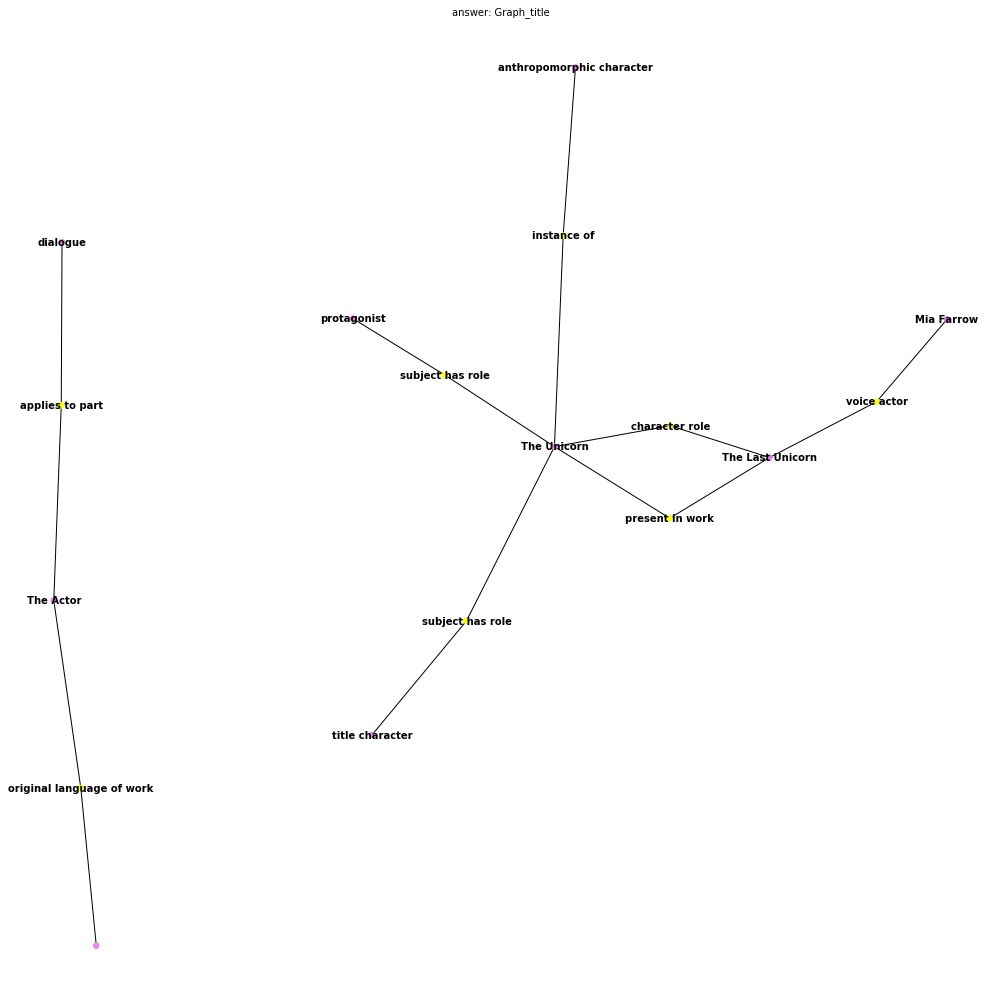

In [139]:
test_graph = make_statements_graph(test_unduplicate_statements)
print(test_graph[1])
plot_graph(test_graph[0], "file_name_graph", "Graph_title")

In [140]:
def get_statements_by_id(statements, from_token_id, to_id, qualifier=False, statement_type="predicate"):
    id_statements = []
    if not statements:
        return id_statements
    if get_wd_label(from_token_id):
        for statement in statements:
            if qualifier:
                if statement.get('qualifiers'):
                    for s in statement['qualifiers']:
                        if to_id == s[statement_type]['id']:
                            id_statements.append(statement)
            else:
                if to_id == statement[statement_type]['id']:
                    id_statements.append(statement)
    
    return id_statements

statements_test = get_all_statements_of_entity('Q176198')
id_statements_test = get_statements_by_id(statements_test, 'Q176198', 'P725')
print(id_statements_test[0])

#get_statements_by_id(root_statements, cluster_root_id, predicate_id, qualifier=False, statement_type="predicate")
#statements_test = get_all_statements_of_entity('Q176198')
#id_statements_test = get_statements_by_id(statements_test, 'Q176198', 'P725')
#id_statements_test[0]

{'entity': {'id': 'Q176198'}, 'predicate': {'id': 'P725'}, 'object': {'id': 'Q202725'}, 'qualifiers': [{'qualifier_predicate': {'id': 'P453'}, 'qualifier_object': {'id': 'Q30060419'}}]}


In [141]:
# parameters
# cluster_root_ids: ['Qcode']
# predicates_ids: ['Pcode']
def cluster_extend_by_predicates_ids(cluster_root_ids, predicates_ids):
    cluster = []
    
    for cluster_root_id in cluster_root_ids:
        root_statements = get_all_statements_of_entity(cluster_root_id)
        #print("root_statements", root_statements)
        for predicate_id in predicates_ids:
            cluster += get_statements_by_id(root_statements, cluster_root_id, predicate_id, qualifier=True, statement_type="qualifier_predicate")
            cluster += get_statements_by_id(root_statements, cluster_root_id, predicate_id, qualifier=False, statement_type="predicate")

    return cluster
    
#test_predicate_clusters = cluster_extend_by_predicates_ids(extract_ids(q0_themes[0]), extract_ids(q0_predicates))
#print(len(test_predicate_clusters))
#test_predicate_clusters[0]

test_predicate_clusters_test_2 = cluster_extend_by_predicates_ids(extract_ids(q0_themes_test_2[0]), extract_ids(q0_predicates_test_2))
print(len(test_predicate_clusters_test_2))
print(test_predicate_clusters_test_2[-1])

10
{'entity': {'id': 'Q13202704'}, 'predicate': {'id': 'P31'}, 'object': {'id': 'Q21286738'}, 'qualifiers': []}


In [142]:
def cluster_extractor_from_complements(complements):
    for c in complements:
        [print(t.pos_) for t in c]
    return complements

print(cluster_extractor_from_complements(q0_themes[1]))

DET
NOUN
DET
PROPN
DET
NOUN
DET
ADJ
NOUN
DET
PROPN
DET
ADJ
PROPN
[Which actor, the Unicorn, the unicorn, the last unicorn, the Unicorn, the last Unicorn]


{'P2842': 1, 'P580': 2, 'P26': 5, 'P279': 1, 'P1476': 1, 'P805': 2, 'P1343': 2, 'P527': 1, 'P1013': 3, 'P1889': 3, 'http://www.w3.org/2002/07/owl#sameAs': 1, 'P585': 2, 'P166': 1, 'P1686': 1, 'P1411': 1, 'P155': 1, 'P108': 1, 'P582': 1, 'P106': 1, 'P1039': 3, 'P3373': 2, 'P1038': 1, 'P31': 20, 'P131': 1, 'P19': 1}


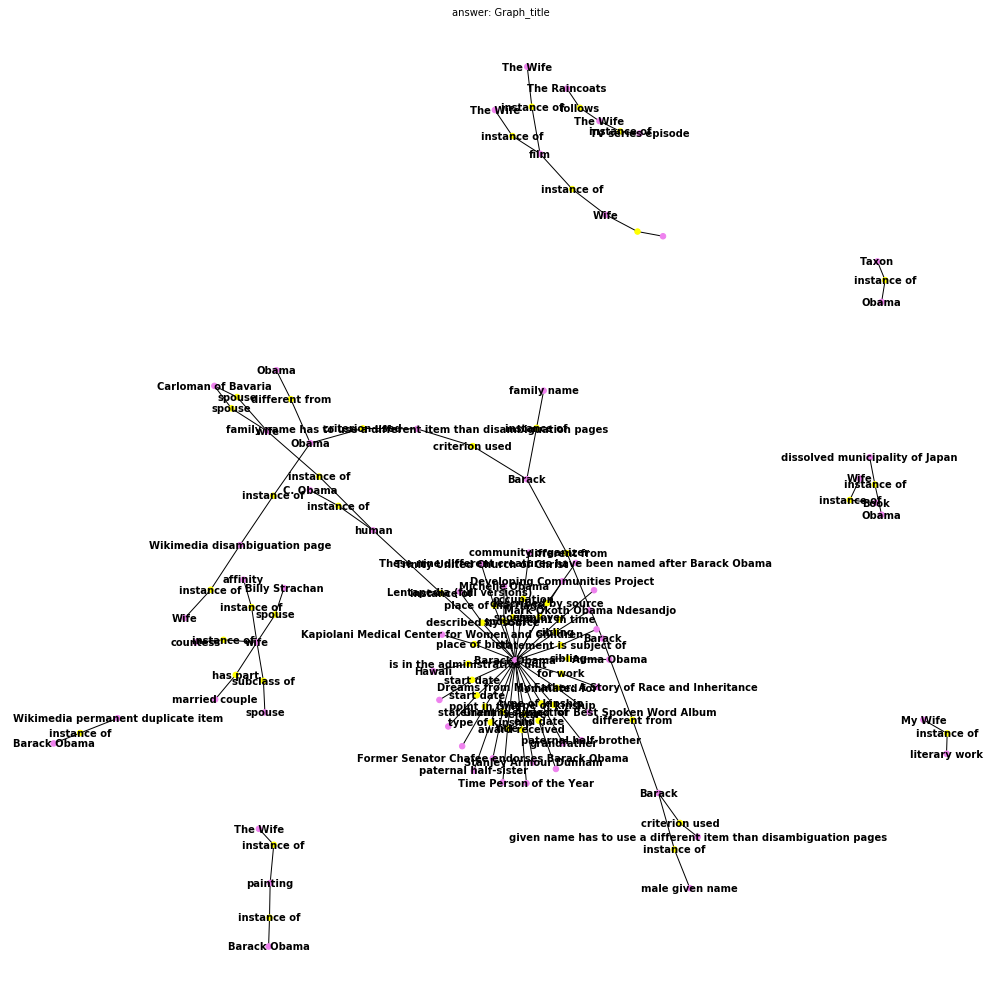

In [143]:
#TODO: add cache
#TODO: Check if extending with predicate_ids is useful
# parameter
# question: nlp_string
#limits=plt.axis('off')
def build_graph(nlp, themes, themes_enhanced, predicates, deep_k=10):
    #start_time = time.time()
    theme_ids = extract_ids(themes[0])
    theme_enhanced_ids = extract_ids(themes_enhanced)
    predicates_ids = extract_ids(predicates)
    predicates_enhanced_ids = [p for p in theme_enhanced_ids if is_wd_predicate(p)]
    predicates_enhanced = merge_lists([get_nlp(get_wd_label(p)) for p in predicates_enhanced_ids], predicates_enhanced_ids)
    
    #print(theme_ids)
    #print(theme_enhanced_ids)
    for i, tei in enumerate(theme_enhanced_ids):
        if tei in theme_ids:
            tmp = theme_enhanced_ids.pop(i)
    
    init_clusters = cluster_extend_by_words(theme_ids, [p[0].text for p in predicates+predicates_enhanced], top_k=deep_k)
    #print("init_clusters",len(init_clusters))
    init_clusters_enhanced = cluster_extend_by_words(theme_enhanced_ids, [p[0].text for p in predicates+predicates_enhanced], top_k=deep_k)
    #print("init_clusters_enhanced",len(init_clusters_enhanced))
    init_sorted_statements = sort_statements_by_similarity(init_clusters + init_clusters_enhanced)
    #print("init_sorted_statements",len(init_sorted_statements))
    init_flatten_statements = statements_flatter([s[1] for s in init_sorted_statements])
    #print("init_flatten_statements",len(init_flatten_statements))
    
    predicate_ids_clusters = cluster_extend_by_predicates_ids(theme_ids, predicates_ids+predicates_enhanced_ids)
    #print("predicate_ids_clusters",len(predicate_ids_clusters))
    predicate_ids_enhanced_clusters = cluster_extend_by_predicates_ids(theme_enhanced_ids, predicates_ids+predicates_enhanced_ids)
    #print("predicate_ids_enhanced_clusters",len(predicate_ids_enhanced_clusters))
    predicate_ids_flatten_statements = statements_flatter(predicate_ids_clusters+predicate_ids_enhanced_clusters)
    #print("predicate_ids_flatten_statements",len(predicate_ids_flatten_statements))
    
    clusters = init_flatten_statements+predicate_ids_flatten_statements
    filtered_statements = unduplicate_statements(clusters)
    #print(predicate_ids_enhanced_clusters)
    graph = make_statements_graph(filtered_statements)

    ##print("clusters:", len(clusters))
    ##print("filtered_statements:", len(filtered_statements))
    #end_time = time.time()
    #print("->\tRunning time is {}s".format(round(end_time-start_time,2)))
    
    return graph

#q0_test = questions[0]
#q0_test = "Which actor voiced the Unicorn in The Last Unicorn?"
#q0_test = "what was the cause of death of yves klein"
q0_test = "Who is the wife of Barack Obama?"
#q0_test = "Who is the author of Le Petit Prince?"
q0_nlp_test = get_nlp(q0_test)
q0_themes_test = get_themes(q0_nlp_test, top_k=3)
q0_themes_enhanced_test = get_enhanced_themes(q0_themes_test, top_k=3)
q0_predicates_test = get_predicates_online(q0_nlp_test, top_k=3)
q0_focused_parts_test = []
graph, predicates_dict = build_graph(q0_nlp_test, q0_themes_test, q0_themes_enhanced_test, q0_predicates_test, deep_k=3)
print(predicates_dict)
plot_graph(graph, "file_name_graph", "Graph_title")

In [144]:
# check the graph for complements
# parameters
# name: string
def find_name_in_graph(graph, name):
    return [x for x,y in graph.nodes(data=True) if y['name'].lower() == name.lower()]

#[find_name_in_graph(c.text) for c in q0_themes[1]]
print(find_name_in_graph(graph, "the unicorn"))

[]


In [145]:
# TODO: clean the complements by removing stopwords etc.
def find_theme_complement(graph, themes):
    return [i for i in itertools.chain.from_iterable(
        [id for id in [c for c in [find_name_in_graph(graph, t.text) for t in themes[1]] if c]])]

print(find_theme_complement(graph, q0_themes_test))
#[i for i in itertools.chain.from_iterable([id for id in check_theme_complement(graph, q0_themes)])]

['Q16205566', 'Q23936005', 'Q28318271', 'Q7774795', 'Q16205566', 'Q23936005', 'Q28318271', 'Q7774795', 'Q76', 'Q47513588', 'Q13202704', 'Q16205566', 'Q23936005', 'Q28318271', 'Q7774795']


In [146]:
def find_paths_in_graph(graph, node_start, node_end):
    return [p for p in nx.all_simple_paths(graph, source=node_start, target=node_end)]
        
test_paths = find_paths_in_graph(graph, "Q16205566", "Q7774795")
print(test_paths)

[]


In [147]:
def is_id_in_graph(graph, node_id):
    return graph.has_node(node_id)
print(is_id_in_graph(graph, "Q24039104"))

True


In [148]:
def is_name_in_graph(graph, node_name):
    return find_name_in_graph(graph, node_name) != []
print(is_name_in_graph(graph, "the Unicorn"))

False


In [149]:
def find_paths_for_themes(graph, themes):
    themes_ids = [t for t in  extract_ids(themes[0])]
    complements_ids = find_theme_complement(graph, themes)
    paths = []
    for t_id in themes_ids:
        if is_id_in_graph(graph, t_id):
            for c_id in complements_ids:
                if is_id_in_graph(graph, c_id):
                    path = find_paths_in_graph(graph, t_id, c_id)
                    if path:
                        paths.append(path)
    paths = [i for i in itertools.chain.from_iterable(
        [id for id in paths])]
    
    return paths
print(find_paths_for_themes(graph, q0_themes_test))
print(find_paths_for_themes(graph, q0_themes))

[['Q47513588', 'P31-1', 'Q3305213', 'P31-5', 'Q23936005'], ['Q47513588', 'P31-1', 'Q3305213', 'P31-5', 'Q23936005'], ['Q47513588', 'P31-1', 'Q3305213', 'P31-5', 'Q23936005'], ['Q47513588', 'P31-1', 'Q3305213', 'P31-5', 'Q23936005'], ['Q47513588', 'P31-1', 'Q3305213', 'P31-5', 'Q23936005'], ['Q47513588', 'P31-1', 'Q3305213', 'P31-5', 'Q23936005'], ['Q47513588', 'P31-1', 'Q3305213', 'P31-5', 'Q23936005'], ['Q47513588', 'P31-1', 'Q3305213', 'P31-5', 'Q23936005'], ['Q47513588', 'P31-1', 'Q3305213', 'P31-5', 'Q23936005'], ['Q23936005', 'P31-5', 'Q3305213', 'P31-1', 'Q47513588']]
[]


In [150]:
def get_node_predicates_from_path(paths):
    predicates = []
    for p in paths:
        [predicates.append(i[:i.find("-")]) for i in p if is_wd_predicate(i[:i.find("-")]) and i[:i.find("-")] not in predicates]
    return predicates

test_node_predicates = get_node_predicates_from_path(test_paths)
print(test_node_predicates)

[]


In [151]:
def get_node_predicate_similarity_from_path(paths, predicates):
    path_predicates = get_node_predicates_from_path(paths)
    return sorted([(pp, get_similarity_by_ids(p2, pp)) for p in predicates for p2 in p[1] for pp in path_predicates], key=lambda x: x[-1], reverse=True)

test_node_pedicate_similarities = get_node_predicate_similarity_from_path(test_paths, q0_predicates)
print(test_node_pedicate_similarities)

[]


In [152]:
def get_focused_parts(nlp_sentence, top_k=3):
    focused_parts = [t.head for t in nlp_sentence if t.tag_ == "WDT" or t.tag_ == "WP" or t.tag_ == "WP$" or t.tag_ == "WRB"] 
    focused_parts_ids = [get_wd_ids(p.text, top_k=top_k) for p in focused_parts]
    return merge_lists(focused_parts, focused_parts_ids)

print(get_focused_parts(q0_nlp_test))

[(is, ['Q294', 'Q189'])]


In [1503]:
questions_2 = ("what was the cause of death of yves klein",
               "Who is the wife of Barack Obama?",
               "Who is the president of the United States?",
               "When was produced the first Matrix movie?",
               "Who made the soundtrack of the The Last Unicorn movie?",
               "Who is the author of Le Petit Prince?",
               "Which actor voiced the Unicorn in The Last Unicorn?",
               "how is called the rabbit in Alice in Wonderland?",
               "what city was alex golfis born in",
               "which stadium do the wests tigers play in",
               "Which nation is Martha Mattox from"
              )

question_2 = questions_2[6] #"what city was alex golfis born in"#
q_nlp_2 = get_nlp(question_2)
q_themes_2 = get_themes(q_nlp_2, top_k=3)
q_themes_enhanced_2 = get_enhanced_themes(q_themes_2, top_k=3)
q_predicates_2 = get_predicates(q_nlp_2, top_k=3)
if q_predicates_2:
        if not q_predicates_2[0][1]: q_predicates_2 = get_predicates_online(q_nlp_2, top_k=3)
q_focused_parts_2 = get_focused_parts(q_nlp_2)
print("q_nlp:", q_nlp_2)
print("e\t\te.pos_\te.tag_\te.dep_\te.head\te.children")
for e in q_nlp_2:
    print(e.text,"\t\t", e.pos_,"\t", e.tag_,"\t", e.dep_,"\t", e.head, "\t", [child for child in e.children])

print("\nq_themes:", q_themes_2)
print("q_themes_enhanced:",q_themes_enhanced_2)
print("q_predicates:", q_predicates_2)
print("q_focused_parts:", q_focused_parts_2)

graph_2, predicates_dict_2 = build_graph(q_nlp_2, q_themes_2, q_themes_enhanced_2, q_predicates_2, deep_k=40)
print(len(graph_2), "nodes and", graph_2.size(), "edges")
print(predicates_dict_2)
#plot_graph(graph_2, "main_graph", "Main_graph_title")
#answers_2 = find_anwser_from_graph_2(graph, q0_nlp, q0_themes, q_themes_enhanced_2, q_predicates_2, q_focused_parts_2)

q_nlp: Who is the wife of Barack Obama?
e		e.pos_	e.tag_	e.dep_	e.head	e.children
Who 		 PRON 	 WP 	 nsubj 	 is 	 []
is 		 AUX 	 VBZ 	 ROOT 	 is 	 [Who, wife, ?]
the 		 DET 	 DT 	 det 	 wife 	 []
wife 		 NOUN 	 NN 	 attr 	 is 	 [the, of]
of 		 ADP 	 IN 	 prep 	 wife 	 [Obama]
Barack 		 PROPN 	 NNP 	 compound 	 Obama 	 []
Obama 		 PROPN 	 NNP 	 pobj 	 of 	 [Barack]
? 		 PUNCT 	 . 	 punct 	 is 	 []

q_themes: ([(Barack Obama, ['Q47513588', 'Q76', 'Q13202704', 'Q47513588', 'Q76', 'Q13202704', 'Q47513588', 'Q76', 'Q13202704', 'Q76']), (The Wife, ['Q16205566', 'Q23936005', 'Q3273509', 'Q19102288'])], [the wife, the wife, barack obama, the wife])
q_themes_enhanced: [('The Wife', ['Q16205566', 'Q23936005', 'Q3273509', 'Q19102288']), ('wife', ['P26', 'Q24039104', 'Q188830']), ('Wife', ['Q28318271', 'Q11447160', 'Q7999459', 'Q7999457', 'Q7774795']), ('Barack Obama', ['Q47513588', 'Q76', 'Q13202704']), ('Barack', ['Q76', 'Q18643532', 'Q37011990', 'Q380650']), ('Obama', ['Q33687029', 'Q223850', '

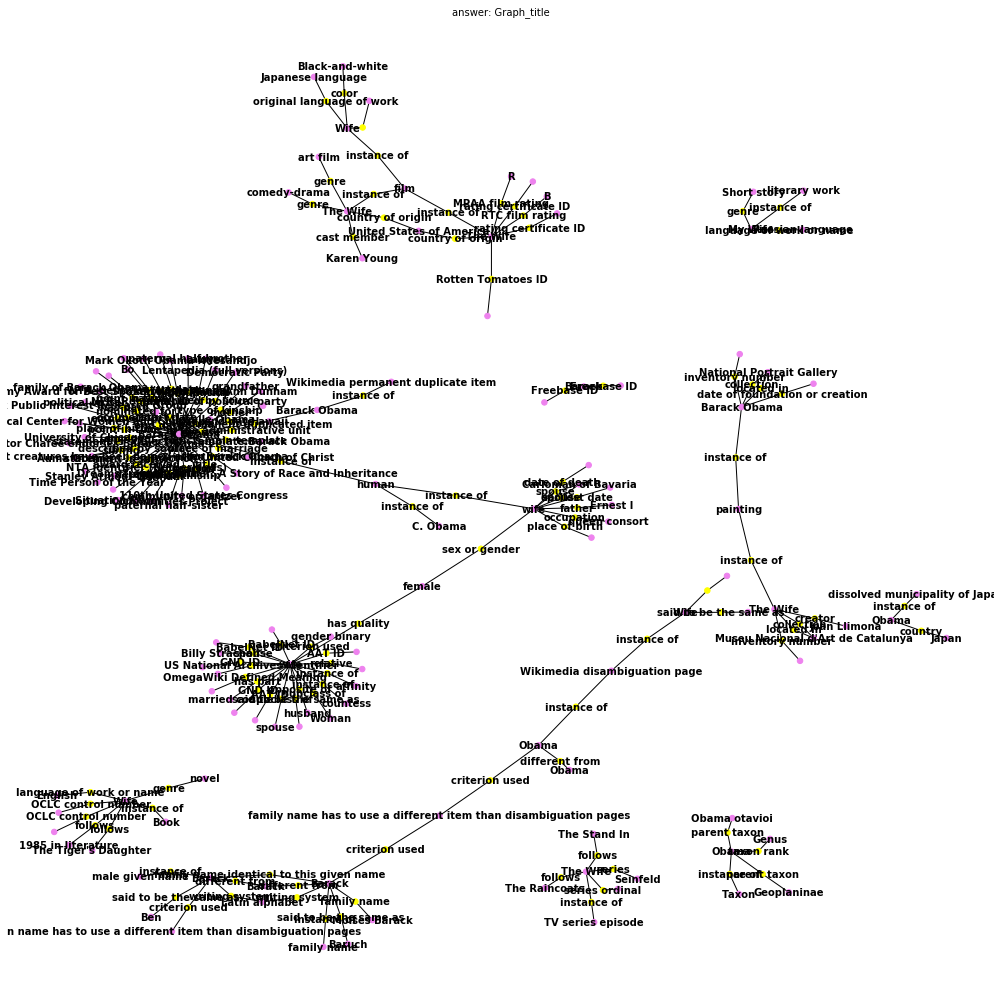

In [1494]:
plot_graph(graph_2, "test_file_name_graph", "Graph_title")

In [1505]:
def add_compound(nlp_list, themes):
    compounded = []
    #if not nlp_list[0]:
    #    return compounded
    try:
        for t in [e[0] for e in themes[0]] + themes[1]:
            for l in [n[0] for n in nlp_list]:
                if l.text.lower() in t.text.lower():
                    compounded.append(t.text)
        return compounded
    except:
        return compounded

# TODO: make the predicate search go further in the path list for the !i%2
def find_paths_keywords(graph, nlp, themes, themes_enhanced, predicates, focused_parts):
    WH_FILTER = ["WDT", "WP", "WP$", "WRB"]
    VERB_FILTER = ["VERB", "AUX"]
    NOUN_FILTER = ["NOUN","PROPN"]
    POSITION_FILTER = ["ADP"]
    
    focused_parts_words = [t[0].text for t in focused_parts]
    focused_parts_ids = [j for i in [t[1] for t in focused_parts] for j in i]
    focused_parts_predicates_ids = [f for f in focused_parts_ids if is_wd_predicate(f)]
    focused_parts_words_ids = [f for f in focused_parts_ids if is_wd_entity(f)]
    focused_parts_words_ids_labeled = [get_wd_label(p) for p in focused_parts_words_ids]
    #print(focused_parts_words_2)

    question_anchors = [t for t in nlp if t.tag_ in WH_FILTER]
    themes_enhanced_list = [t[0] for t in themes_enhanced]
    focus_themes = [t[0].text for t in themes[0]]
    focus_path_by_tails = [[c for c in t.head.children if c.pos_ in NOUN_FILTER] for t in nlp if t.pos_ == "PRON"]
    focus_part_by_head = [t.head for t in question_anchors]
    predicates_nlp = [t for t in nlp if t.pos_ in VERB_FILTER]
    predicates_lemma = [t.lemma_ for t in predicates_nlp]
    predicates_attention = [t for t in nlp if t.head in predicates_nlp]
    predicates_attention_tails = [[c for c in t.children] for t in predicates_attention]
    in_attention_heads = [t.head.text for t in nlp if t.pos_ in POSITION_FILTER]
    in_attention_tails = add_compound([[c for c in t.children] for t in nlp if t.pos_ in POSITION_FILTER], themes)
    focus_themes_enhanced = [t[0] for t in themes_enhanced
                             if t[0].lower() in [a.lower() for a in in_attention_tails]
                             or t[0].lower() in [a.lower() for a in in_attention_heads]]
    
    theme_enhanced_ids = extract_ids(themes_enhanced)
    predicates_enhanced_ids = [(p) for p in theme_enhanced_ids if is_wd_predicate(p)]
    [predicates_enhanced_ids.append(p) for p in focused_parts_predicates_ids if p not in predicates_enhanced_ids]
    
    alterniative_words = {}
    for t in themes_enhanced:
        for e in predicates_enhanced_ids:
            if e in t[1]:
                alterniative_words[t[0]] = [get_nlp(get_wd_label(e)),[e]]
            else:
                alterniative_words[get_wd_label(e)] = [get_nlp(get_wd_label(e)),[e]]
    
    #print("focused_parts_predicates_ids",focused_parts_predicates_ids)
    #print("focused_parts_words_ids",focused_parts_words_ids)
    #print("alterniative_words",alterniative_words)
    #print("predicates_enhanced_ids",predicates_enhanced_ids)
    ##print("predicates_enhanced",predicates_enhanced)
    #print("question_anchors",question_anchors)
    #print("in_attention_heads",in_attention_heads)
    #print("in_attention_tails",in_attention_tails)
    #print("focus_themes",focus_themes)
    #print("themes_enhanced_list",themes_enhanced_list)
    #print("focus_themes_enhanced",focus_themes_enhanced)
    #print("focus_path_by_tails",focus_path_by_tails)
    #print("focus_part_by_head",focus_part_by_head)
    #print("predicates_nlp",predicates_nlp)
    #print("predicates_lemma",predicates_lemma)
    #print("predicates_attention",predicates_attention)
    #print("predicates_attention_tails",predicates_attention_tails)
    #
    #print("\n")
    paths_keywords = []
    [paths_keywords.append(e.lower()) for e in focused_parts_words + in_attention_heads + in_attention_tails + focus_themes + focus_themes_enhanced + focused_parts_words_ids_labeled if e.lower() not in paths_keywords]
    #print(paths_keywords)
    #paths_keywords = [p for p in itertools.permutations(paths_keywords)]
    #print(paths_keywords)
    return paths_keywords, alterniative_words, question_anchors
    
    #initial_paths = find_paths_for_themes(graph, themes)
    #predicate_id_similarities = get_node_predicate_similarity_from_path(initial_paths, predicates)
    #best_path = [p for p in initial_paths if predicate_id_similarities[0][0] == p[1][:p[1].find("-")]]
    #path_answer = get_wd_label(best_path[0][2]) if best_path else []
    
    #return (path_answer, best_path[0][2]) if path_answer else (False, False)

paths_keywords_2 = find_paths_keywords(graph_2, q_nlp_2, q_themes_2, q_themes_enhanced_2, q_predicates_2, q_focused_parts_2)
paths_keywords_2

(['is', 'wife', 'barack obama', 'the wife', 'icelandic language', 'iceland'],
 {'spouse': [spouse, ['P26']], 'wife': [spouse, ['P26']]},
 [Who])

In [1506]:
def get_paths_keywords_nodes(graph, keywords,threshold=0.9,top_performance=50):
    keywords_nodes = []
    for k in keywords:
        nlp_lookup = get_nlp(k)
        keywords_nodes.append([x for x,y in graph.nodes(data=True)
               if get_nlp(y['name']).similarity(nlp_lookup) >= threshold])
    
    if keywords_nodes:
        if len(keywords_nodes[1]) * len(keywords_nodes[0]) > top_performance:
            if len(keywords_nodes[0]) <= int(sqrt(top_performance)):
                keywords_nodes[1] = keywords_nodes[1][:int(top_performance/len(keywords_nodes[0]))]
            elif len(keywords_nodes[0]) >= len(keywords_nodes[1]):
                keywords_nodes[0] = keywords_nodes[0][:int(top_performance/len(keywords_nodes[1]))]
            else:
                keywords_nodes[0] = keywords_nodes[0][:int(sqrt(top_performance))]
                keywords_nodes[1] = keywords_nodes[1][:int(sqrt(top_performance))]
    
    keywords_nodes_per = [p for p in itertools.permutations(keywords_nodes, 2)]
    
    paths_keyword_nodes = []
    for pkn in keywords_nodes_per:
        for pkn1 in pkn[0]:
            for pkn2 in pkn[1]:
                [paths_keyword_nodes.append(p) for p in nx.all_simple_paths(graph, source=pkn1, target=pkn2) if p not in paths_keyword_nodes]
    
    return paths_keyword_nodes

def find_path_nodes_from_graph_2(graph, keywords, threshold=0.9, thres_inter=0.15, top_k=3, top_performance=50,min_paths=3000):
    #print("current threshold", str(round(threshold, 1)))
    main_keyword_paths = get_paths_keywords_nodes(graph, keywords[0],threshold=threshold,top_performance=top_performance)
    alternative_keyword_paths = []
    
    for k_1 in keywords[1]:
        for i, k_0 in enumerate(keywords[0]):
            if k_1==k_0:
                tmp_keywords = keywords[0].copy()
                tmp_keywords[i] = keywords[1][k_1][0].text
                alternative_keyword_paths += get_paths_keywords_nodes(graph, tmp_keywords, threshold=threshold,top_performance=top_performance)
    
    keyword_paths = main_keyword_paths+alternative_keyword_paths
    
    #print("len(keyword_paths)",len(keyword_paths))
    if len(keyword_paths) < min_paths:
        if threshold == 0: return keyword_paths
        threshold -= thres_inter
        if threshold < 0: threshold = 0
        keyword_paths = find_path_nodes_from_graph_2(graph, keywords, threshold, thres_inter, top_k,top_performance,min_paths)
    
    return keyword_paths

start_time = time.time()
path_nodes_2 = find_path_nodes_from_graph_2(graph_2, paths_keywords_2, threshold=0.9, thres_inter=0.15, top_performance=50, min_paths=3000)
end_time = time.time()
print("Finding path nodes ->\tRunning time is {}s".format(round(end_time-start_time,2))) 
print(path_nodes_2)

Finding path nodes ->	Running time is 138.3s
7548


In [1504]:
print(len(path_nodes_2))

3582


In [1507]:
#node_predicates_names_2 = get_node_predicates_from_path(path_nodes_2)

def is_sublist(a, b):
    if not a: return True
    if not b: return False
    #if a == b: return False
    return b[:len(a)] == a or is_sublist(a, b[1:])

def paths_nodes_filter(path_nodes, graph):
    filtered_paths = []
    
    for path in path_nodes:
        filtered_row = []
        for i,p in enumerate(path):
            if is_wd_predicate(p[:p.find("-")]):
                if i == 0:
                    #if p[:p.find("-")] == "P725":
                    #    print(p)
                    neighbor = [k for k in graph[p].keys() if k != path[i+1]]
                    if neighbor:
                        filtered_row.append(neighbor[0])
                        filtered_row.append(p[:p.find("-")])
                    else:
                        continue
                    #print(filtered_row)
                elif i > 0 and i < len(path)-1:
                    filtered_row.append(p[:p.find("-")])
                else:
                    neighbor = [k for k in graph[p].keys() if k != path[i-1]]
                    if neighbor:
                        filtered_row.append(p[:p.find("-")])
                        filtered_row.append(neighbor[0])
                    else:
                        continue
            else: filtered_row.append(p)
        
        #print("filtered_paths",filtered_paths)
        
        if len(filtered_row) > 1 and filtered_row not in filtered_paths: 
            filtered_paths.append(filtered_row)
    
    unique_paths = filtered_paths.copy()
    for i,fp in enumerate(filtered_paths):
        for fp_2 in filtered_paths:
            if (is_sublist(fp, fp_2) and fp!=fp_2):
                unique_paths[i] = []
                break
    
    unique_paths = [p for p in unique_paths if p]
    
    #print("unique_paths",len(unique_paths))
    
    #for i, up in enumerate(unique_paths):
    #    for up_2 in unique_paths:
    #        if (list(reversed(up)) == up_2):
    #            unique_paths[i] = []
    #            break
    
    
    #cleaned_paths = []
    #unique_paths = [up for up in unique_paths if up]
    
    #for up in unique_paths:
    #    for i,e in enumerate(up):
    #        if not is_wd_predicate(e):
    #            for j,r in enumerate(list(reversed(up))): 
    #                if not is_wd_predicate(r):
    #                    cleaned_paths.append(up[i:-j])
    #            break
                
    #print("cleaned_paths",len(cleaned_paths))
                
    #cleaned_paths = [c for c in cleaned_paths if len(c) > 2]
    
    #unique_paths = cleaned_paths.copy()
    #for i,fp in enumerate(cleaned_paths):
    #    for fp_2 in cleaned_paths:
    #        if (is_sublist(fp, fp_2) and fp!=fp_2):
    #            unique_paths[i] = []
    #            break
    
    #unique_paths = [p for p in unique_paths if len(p) > 2]       
    
    #for i, up in enumerate(unique_paths):
    #    for up_2 in unique_paths:
    #        if (list(reversed(up)) == up_2):
    #            unique_paths[i] = []
    #            break
        
        #print(up)
    #[up for up in unique_paths if up and not is_wd_predicate(up[-1]) and not is_wd_predicate(up[0])]
    #print()
    #for up in unique_paths:
    #    print(up)
    #    break
    #    return []
    
    return [p for p in unique_paths if len(p) > 2] #False#[up for up in unique_paths if up and not is_wd_predicate(up[-1]) and not is_wd_predicate(up[0])]#False# [p for p in unique_paths if p]
                
paths_nodes_filtered_2 = paths_nodes_filter(path_nodes_2, graph_2)
print("unique_paths", len(paths_nodes_filtered_2))
pprint(paths_nodes_filtered_2)

unique_paths 1692
[['Q10703919', 'P2842', 'Q76', 'P26', 'Q13133', 'P26', 'Q76'],
 ['Q10703919',
  'P2842',
  'Q76',
  'P31',
  'Q5',
  'P31',
  'Q24039104',
  'P26',
  'Q157084',
  'P26',
  'Q24039104'],
 ['Q10703919',
  'P2842',
  'Q76',
  'P31',
  'Q5',
  'P31',
  'Q24039104',
  'P21',
  'Q6581072',
  'P1552',
  'Q188830',
  'P26',
  'Q18531596'],
 ['Q10703919',
  'P2842',
  'Q76',
  'P31',
  'Q5',
  'P31',
  'Q24039104',
  'P21',
  'Q6581072',
  'P1552',
  'Q188830',
  'P279',
  'Q1196129'],
 ['Q10703919',
  'P2842',
  'Q76',
  'P31',
  'Q5',
  'P31',
  'Q24039104',
  'P21',
  'Q6581072',
  'P1552',
  'Q188830',
  'P527',
  'Q3046146'],
 ['Q10703919', 'P2842', 'Q76', 'P1686', 'Q1305386'],
 ['Q10703919', 'P2842', 'Q76', 'P25', 'Q766106'],
 ['Q10703919',
  'P2842',
  'Q76',
  'P31',
  'Q5',
  'P31',
  'Q24039104',
  'P22',
  'Q3155966'],
 ['Q10703919', 'P2842', 'Q76', 'P1039', 'Q19595228'],
 ['Q10703919', 'P2842', 'Q76', 'P1039', 'Q19595226'],
 ['Q10703919', 'P2842', 'Q76', 'P1039', '

 ['Q3155966',
  'P22',
  'Q24039104',
  'P21',
  'Q6581072',
  'P1552',
  'Q188830',
  'P31',
  'Q954007'],
 ['Q3155966',
  'P22',
  'Q24039104',
  'P21',
  'Q6581072',
  'P1552',
  'Q188830',
  'P31',
  'Q5177051'],
 ['Q12308941',
  'P31',
  'Q18643532',
  'P1889',
  'Q423373',
  'P1889',
  'Q37011990',
  'P1013',
  'Q27924673',
  'P1013',
  'Q223850',
  'P31',
  'Q4167410',
  'P31',
  'Q7999457',
  'P460',
  'Q8778716'],
 ['Q12308941',
  'P31',
  'Q18643532',
  'P1533',
  'Q37011990',
  'P1013',
  'Q27924673',
  'P1013',
  'Q223850',
  'P31',
  'Q4167410',
  'P31',
  'Q7999457',
  'P460',
  'Q8778716'],
 ['Q12308941',
  'P31',
  'Q18643532',
  'P282',
  'Q8229',
  'P282',
  'Q37011990',
  'P1013',
  'Q27924673',
  'P1013',
  'Q223850',
  'P31',
  'Q4167410',
  'P31',
  'Q7999457',
  'P460',
  'Q8778716'],
 ['Q12308941', 'P31', 'Q18643532', 'P460', 'Q816407'],
 ['Q12308941',
  'P31',
  'Q18643532',
  'P1889',
  'Q423373',
  'P1889',
  'Q37011990',
  'P460',
  'Q37237941'],
 ['Q1230894

  'Q24039104',
  'P21',
  'Q6581072',
  'P1552',
  'Q188830',
  'P26',
  'Q18531596'],
 ['1988-01-01T00:00:00Z',
  'P582',
  'Q76',
  'P31',
  'Q5',
  'P31',
  'Q24039104',
  'P21',
  'Q6581072',
  'P1552',
  'Q188830',
  'P279',
  'Q1196129'],
 ['1988-01-01T00:00:00Z',
  'P582',
  'Q76',
  'P31',
  'Q5',
  'P31',
  'Q24039104',
  'P21',
  'Q6581072',
  'P1552',
  'Q188830',
  'P527',
  'Q3046146'],
 ['1988-01-01T00:00:00Z', 'P582', 'Q76', 'P1686', 'Q1305386'],
 ['1988-01-01T00:00:00Z', 'P582', 'Q76', 'P25', 'Q766106'],
 ['1988-01-01T00:00:00Z',
  'P582',
  'Q76',
  'P31',
  'Q5',
  'P31',
  'Q24039104',
  'P22',
  'Q3155966'],
 ['1988-01-01T00:00:00Z', 'P582', 'Q76', 'P1039', 'Q19595228'],
 ['1988-01-01T00:00:00Z', 'P582', 'Q76', 'P1039', 'Q19595226'],
 ['1988-01-01T00:00:00Z', 'P582', 'Q76', 'P1039', 'Q9238344'],
 ['1988-01-01T00:00:00Z',
  'P582',
  'Q76',
  'P31',
  'Q5',
  'P31',
  'Q24039104',
  'P21',
  'Q6581072',
  'P1552',
  'Q188830',
  'P461',
  'Q212878'],
 ['1988-01-01T00

In [1498]:
def get_hypothesises(nlp, paths_keywords, filtered_paths):#, themes, themes_enhanced):
    #print(paths_keywords)
    #print([p for p in paths_keywords[1].values])
    complementary_predicates = [p[0] for p in list(paths_keywords[1].values())]
    
    #print(complementary_predicates)
    #locate positions   
    anchors_positions = []
    anchors_focuses = []
    #keywords_positions = []
    #predicates_positions = []
    
    [anchors_positions.append(i) for i, w in enumerate(nlp) if w in paths_keywords[2]]
    #print("anchors_positions 1",anchors_positions)
    
    #anchors_childrens
    for p in anchors_positions:
        children = [c for c in nlp[p].children]
        if children == []: 
            children = [c for c in nlp[p].head.children]
        else: children += nlp[p].head
        anchors_focuses += ([c for c in children
               if c not in [nlp[a] for a in anchors_positions]
               and c.pos_ != "PUNCT"])
        if not anchors_focuses:
            anchors_focuses = [nlp[p].head]
        
        #print(anchors_focuses)
        anchors_focuses += complementary_predicates
    
    #[anchors_focuses_filtered.append(af) for af in anchors_focuses if af not in anchors_focuses_filtered]
    #print("anchors_focuses",anchors_focuses_filtered)
    
    
    #find anchor position in paths
    anchors_predicates = []
    #print("filtered_paths",filtered_paths)
    for af in anchors_focuses:
        for p in filtered_paths:
            #print(af, p)
            for e in p:
                #print(af,get_wd_label(e))
                if is_wd_predicate(e) and e not in [ap[0] for ap in anchors_predicates]:
                    #print(af,get_wd_label(e))
                    anchors_predicates.append([e, get_similarity_by_words(get_nlp(get_wd_label(e)),af)])
                
    #print("anchors_predicates",anchors_predicates)
    #for p in filtered_paths:
    #    for af in anchors_focuses:
    #        for e in p:
    #            #print(af,get_wd_label(e))
    #            if is_wd_predicate(e) and e not in [ap[0] for ap in anchors_predicates]:
    #                #print(af,get_wd_label(e))
    #                anchors_predicates.append([e, get_similarity_by_words(get_nlp(get_wd_label(e)),af)])
                
    anchors_predicates = [a for a in sorted(anchors_predicates, key=lambda x: x[-1], reverse=True) if a[1] > 0.5]
    #print("anchors_predicates",anchors_predicates)
    
    anchors_predicates_filtered = []
    for ap in anchors_predicates:
        for af in anchors_focuses:
            anchors_predicates_filtered.append([ap[0],get_similarity_by_words(get_nlp(get_wd_label(ap[0])),af)])
    
    if not anchors_predicates_filtered:
        anchors_predicates_filtered = anchors_predicates
    
    anchors_predicates_filtered = [a for a in sorted(anchors_predicates_filtered, key=lambda x: x[-1], reverse=True) if a[1] > 0.5]
    #print("anchors_predicates_filtered",anchors_predicates_filtered)
    
    anchors_predicates=[]
    [anchors_predicates.append(apf) for apf in anchors_predicates_filtered if apf not in anchors_predicates]
    #print("anchors_predicates",anchors_predicates)
    
    hypothesises_tuples = []
    for ap in anchors_predicates:
        for fp in filtered_paths:
            for i, e in enumerate(fp):
                #print(e)
                if e == ap[0] and i>1 and i<len(fp)-1:
                    #print(i, [fp[i-1], fp[i], fp[i+1]])
                    hypothesis_tuple = [fp[i-1], fp[i], fp[i+1]]
                    if hypothesis_tuple not in hypothesises_tuples:
                        hypothesises_tuples.append(hypothesis_tuple)
                        
    #print("hypothesises_tuples",hypothesises_tuples)
    #print("hypothesises_tuples",hypothesises_tuples)
    #print([a[0] for a in anchors_predicates])
    keywords_names = [k for k in paths_keywords[0]]
    #print("keywords_names",keywords_names)
    #keywords_ids = [i for j in [get_wd_ids(k) for k in keywords_names if get_wd_ids(k)] for i in j]
    #print("keywords_names",keywords_ids)
    #print(extract_ids(themes[0]))
    #print(extract_ids(themes_enhanced))
    #keywords_ids = []
    #[keywords_ids.append(i) for i in extract_ids(themes[0]) + extract_ids(themes_enhanced) if i not in keywords_ids]
    #print("keywords_ids",keywords_ids)
    
    #print("anchors_predicates",anchors_predicates)
    
    hypothesises = []
    for ht in hypothesises_tuples:
        if ht[1] in [a[0] for a in anchors_predicates]:
            #rint(ht)
        #if ht[1] == anchors_predicates[0][0]:
            for k in paths_keywords[0]:
                hypo_sum = 0
                nlp_k = get_nlp(k)
                nlp_ht2 = get_nlp(get_wd_label(ht[2]))
                if not nlp_ht2:
                    break

                k_lemma = ' '.join([e.lower_ for e in nlp_k if e.pos_ != "DET"])
                ht2_lemma = ' '.join([e.lower_ for e in nlp_ht2 if e.pos_ != "DET"])
                
                if (nlp_k.text.lower() != nlp_ht2.text.lower() 
                    and k_lemma != nlp_ht2[0].text.lower()
                    and nlp_k.text.lower() != ht2_lemma
                    and k_lemma != ht2_lemma
                   ):
                    hypo_sum += get_similarity_by_words(nlp_ht2, nlp_k)
                    for ap in anchors_predicates:
                        #print("ap",ap, "ht",ht, "hypo_sum",hypo_sum)
                        if ap[0] == ht[1]:
                            hypo_sum = abs(hypo_sum)
                            if get_wd_label(ht[0]).lower() in keywords_names:
                                hypo_sum += abs(ap[1])
                            if get_wd_label(ht[2]).lower() in keywords_names:
                                hypo_sum += abs(ap[1])
                            #else: hypo_sum = ap[1]
                            #hypo_sum *= abs(ap[1])
                                                        
                            
                            #break
                            #print("ap",ap, "ht",ht, "hypo_sum",hypo_sum)
                            #print(ht)
                            #break
                            #hypo_sum = abs(hypo_sum)
                            #hypo_sum += abs(ap[1])
                            #hypo_sum += abs(ap[1])
                            #hypo_sum += ap[1]
                            #hypo_sum += abs(hypo_sum)
                            #hypo_sum *= abs(ap[1])
                            
                            
                            #hypo_sum = abs(hypo_sum)
                            #hypo_sum /= ap[1]
                            #hypo_sum -= ap[1]
                            #hypo_sum += hypo_sum/ap[1]
                        
                            
                    #print(paths_keywords[1])
                    if get_wd_label(ht[0]).lower() in paths_keywords[0]: 
                        if get_wd_label(ht[2]).lower() in paths_keywords[0]:
                            continue
                        else:
                            hypo = ht[2]
                    else: hypo = ht[0]

                    if not hypothesises: hypothesises.append([hypo, hypo_sum])
                    else: 
                        if hypo in [h[0] for h in hypothesises]:
                            for i, h in enumerate(hypothesises):
                                if hypo == h[0]: hypothesises[i] = [hypo, hypo_sum*hypothesises[i][1]]
                        else: hypothesises.append([hypo, hypo_sum])
    
    return sorted(hypothesises, key=lambda x: x[-1], reverse=True)
    
hypothesises_2 = get_hypothesises(q_nlp_2, paths_keywords_2, paths_nodes_filtered_2)#, q_themes_2, q_themes_enhanced_2)
#print("q_nlp_2", q_nlp_2)
#print("paths_keywords_2", paths_keywords_2)
#print("paths_nodes_filtered", paths_nodes_filtered)
#print("hypothesises_2", hypothesises_2)
#print(hypothesises_2)
print([(get_wd_label(h[0]),h[1]) for i,h in enumerate(hypothesises_2)])

[('Michelle Obama', 1322.0332926712813), ('Carloman of Bavaria', 450.7697856783121), ('Billy Strachan', 368.16529377577314), ('Ann Dunham', 161.1372290231955), ('Ernest I', 85.01314308620485), ('Trinity United Church of Christ', 22.520028460281033), ('Moises Barack', 4.2906641343102044e-05), ('Barack', 4.2906641343102044e-05), ('Barack', 4.484735632444219e-11)]


In [1508]:
graph_2.has_node("P495")

False

In [1544]:
def list_by_n(l, i):
    list_n = []
    for j in range(0, len(l)+1, 1):
        tmp = l[j-i:i+j-i]
        if tmp:
            list_n.append(tmp)
    return list_n

def match_hypothesises(graph, question, themes, predicates, hypothesises, paths):
    meaningful_paths = []
    
    theme_ids = sum([t[1] for t in themes[0]],[])
    for p in paths:
        counter = 0
        for ti in theme_ids:
            if ti in p and p not in meaningful_paths:
                counter += 1
        for pred in [p[1] for p in predicates]:
            for e in pred:
                if e in p:
                    counter += 1
                else:
                    counter = 0
        for hypo in hypothesises:
            if hypo[0] in p:
                counter += 1
            if hypo[0] == p[0]:
                counter += 1
            if hypo[0] == p[-1]:
                counter += 1
        
        if counter > 0: meaningful_paths.append((counter, p))

    meaningful_paths = sorted(meaningful_paths, key=lambda x: x[0], reverse=True)
    #print("meaningful_paths:",len(meaningful_paths))
    #print("\n")
    
    looped_paths = []
    for hypo in hypothesises:
        for mp in meaningful_paths:
            if mp[1][0] == hypo[0] or mp[1][-1] == hypo[0]:
                if graph.has_node(mp[1][0]) and graph.has_node(mp[1][-1]):
                    path_tmp = list(nx.all_simple_paths(graph, mp[1][0],mp[1][-1]))
                    if len(path_tmp)>1:
                        for p in path_tmp:
                            if p not in [lp[1] for lp in looped_paths]:
                                looped_paths.append((mp[0],p))
                #else:
                #    if not graph.has_node(mp[1][0]):
                #        print("MISSING NODE:", mp[1][0], get_wd_label(mp[1][0]))
                #    if not graph.has_node(mp[1][-1]):
                #        print("MISSING NODE:", mp[1][-1], get_wd_label(mp[1][-1]))
                
    #print("looped_paths", len(looped_paths))
    
    looped_paths_untagged = []
    for lp in looped_paths:
        row_tmp = []
        for w in lp[1]:
            if w.find("-") > 0:
                row_tmp.append(w[:w.find("-")])
            else:
                row_tmp.append(w)
        looped_paths_untagged.append((lp[0],row_tmp))
        
    #print("looped_paths_untagged",looped_paths_untagged)
    
    mp_similarities_untagged = []
    mp_similarities_tagged = []
    for i_lp, lp in enumerate(looped_paths_untagged):
        #print(lp)
        sentence = get_nlp(" ".join([get_wd_label(w) for w in lp[1]]))
        similarity = get_similarity_by_words(sentence, question)
        #print(similarity, sentence)
        mp_similarities_untagged.append((similarity,lp[1]))
        mp_similarities_tagged.append((similarity,looped_paths[i_lp][1]))
        
    #print("mp_similarities_untagged",len(mp_similarities_untagged))
    #print("mp_similarities_untagged",mp_similarities_untagged)
    
    mp_similarities_tagged = sorted(mp_similarities_tagged, key=lambda x: x[0], reverse=True)
    mp_similarities_tagged = [mp for mp in mp_similarities_tagged if mp[0] > 0.9]
    
    mp_similarities_untagged = sorted(mp_similarities_untagged, key=lambda x: x[0], reverse=True)
    mp_similarities_untagged = [mp for mp in mp_similarities_untagged if mp[0] > 0.9]
    
    #print("mp_similarities_untagged",len(mp_similarities_untagged))
    #print("mp_similarities_tagged",len(mp_similarities_tagged))
    
    WH_FILTER = ["WDT", "WP", "WP$", "WRB"]
    wh_position = [w.i for w in question if w.tag_ in WH_FILTER][0]
    question_list = [w.lower_ for w in question if not w.is_punct]
    question_list_filtered = [w.lower_ for w in question if not w.is_punct and w.tag_ not in WH_FILTER]
    
    golden_paths = []
    for mp in mp_similarities_tagged:
        #print("mp[1]",mp[1])
        for i_e, e in enumerate(mp[1]):
            if i_e <= 1 or i_e >= len(mp[1])-2:
                continue
            if not is_wd_entity(e):
                continue

            mp_e_statements = get_all_statements_of_entity(e)
            extended_paths = get_statements_by_id(mp_e_statements, e, mp[1][i_e+1][:mp[1][i_e+1].find("-")], qualifier=False, statement_type="predicate")
            extended_paths_qualifier = get_statements_by_id(mp_e_statements, e, mp[1][i_e+1][:mp[1][i_e+1].find("-")], qualifier=True, statement_type="qualifier_predicate")

            for ep in extended_paths_qualifier:
                if (ep['entity']['id'] == mp[1][i_e] and 
                    ep['predicate']['id'] == mp[1][i_e-1][:mp[1][i_e-1].find("-")] and
                    ep['object']['id'] == mp[1][i_e-2] and
                    ep['qualifiers']):
                    for q in ep['qualifiers']:
                        if(q['qualifier_predicate']["id"] == mp[1][i_e+1][:mp[1][i_e+1].find("-")] and
                          q['qualifier_object']["id"] == mp[1][i_e+2]):
                            if mp[1] not in golden_paths:
                                golden_paths.append(mp[1])

                if (ep['entity']['id'] == mp[1][i_e+2] and 
                    ep['predicate']['id'] == mp[1][i_e+1][:mp[1][i_e+1].find("-")] and
                    ep['object']['id'] == mp[1][i_e] and
                    ep['qualifiers']):
                    for q in ep['qualifiers']:
                        if(q['qualifier_predicate']["id"] == mp[1][i_e-1][:mp[1][i_e-1].find("-")] and
                          q['qualifier_object']["id"] == mp[1][i_e-2]):
                            if mp[1] not in golden_paths:
                                golden_paths.append(mp[1])

            for ep in extended_paths:
                if (ep['entity']['id'] == mp[1][i_e] and 
                    ep['predicate']['id'] == mp[1][i_e-1][:mp[1][i_e-1].find("-")] and
                    ep['object']['id'] == mp[1][i_e-2] and
                    ep['qualifiers']):
                    for q in ep['qualifiers']:
                        if(q['qualifier_predicate']["id"] == mp[1][i_e+1][:mp[1][i_e+1].find("-")] and
                          q['qualifier_object']["id"] == mp[1][i_e+2]):
                            if mp[1] not in golden_paths:
                                golden_paths.append(mp[1])

                if (ep['entity']['id'] == mp[1][i_e+2] and 
                    ep['predicate']['id'] == mp[1][i_e+1][:mp[1][i_e+1].find("-")] and
                    ep['object']['id'] == mp[1][i_e] and
                    ep['qualifiers']):
                    for q in ep['qualifiers']:
                        if(q['qualifier_predicate']["id"] == mp[1][i_e-1][:mp[1][i_e-1].find("-")] and
                          q['qualifier_object']["id"] == mp[1][i_e-2]):
                            if mp[1] not in golden_paths:
                                golden_paths.append(mp[1])    

    sorted_golden_paths = []
    for gp in golden_paths:
        tmp_gp = []
        for e in gp:
            if is_wd_entity(e):
                tmp_gp.append(get_wd_label(e))
            else:
                tmp_gp.append(get_wd_label(e[:e.find("-")]))
        nlp_gp = get_nlp(" ".join(tmp_gp))
        sorted_golden_paths.append((get_similarity_by_words(question,nlp_gp), gp))

    sorted_golden_paths = sorted(sorted_golden_paths, key=lambda x: x[0], reverse=True)
    #print("len(sorted_golden_paths) BEFORE",len(sorted_golden_paths))
    
    sorted_golden_paths = [sgp[1] for sgp in sorted_golden_paths]
    
    if not sorted_golden_paths: 
        for lp in [lp[1] for lp in looped_paths]:
            if lp[0] == hypothesises[0][0]:
                if lp not in sorted_golden_paths:
                    sorted_golden_paths.append(lp)
            if lp[-1] == hypothesises[0][0]:
                lp = list(reversed(lp))
                if lp not in sorted_golden_paths:
                    sorted_golden_paths.append(lp)
    
    #print("len(sorted_golden_paths) AFTER",len(sorted_golden_paths))
        
    if not sorted_golden_paths: 
        for p in paths:
            #print(p)
            if p[0] == hypothesises[0][0]:
                #print(p)
                if p not in sorted_golden_paths:
                    sorted_golden_paths.append(p)
            if p[-1] == hypothesises[0][0]:
                p = list(reversed(p))
                if p not in sorted_golden_paths:
                    sorted_golden_paths.append(p)
                    
    #print("len(sorted_golden_paths) AFTER AFTER",len(sorted_golden_paths))
    
    if not sorted_golden_paths:
        for p in paths:
            if hypothesises[0][0] in p:
                if p not in sorted_golden_paths:
                    sorted_golden_paths.append([hypothesises[0][0]]+p)
                    
    #print("len(sorted_golden_paths) AFTER AFTER AFTER",len(sorted_golden_paths))
    
    
    golden_paths_filtered = []
    for gp in sorted_golden_paths:
        tmp_path = []
        for i_e, e in enumerate(gp):
            if i_e < len(gp)-2 and not is_wd_entity(e):
                if e == gp[i_e+2]:
                    golden_paths_filtered.append(gp[:gp.index(e)+2])
                    break
                else:
                    tmp_path.append(e)
            else:
                tmp_path.append(e)
        
        if tmp_path:
            for i_e, e in enumerate(tmp_path):
                if is_wd_entity(e):
                    if tmp_path.count(e) > 1:
                        pass
                    else:
                        if tmp_path not in golden_paths_filtered:
                            golden_paths_filtered.append(tmp_path)
                            
    #print("len(golden_paths_filtered)",len(golden_paths_filtered))
    
    golden_unique_paths = golden_paths_filtered.copy()
    for i_sgp, sgp in enumerate(golden_paths_filtered):
        for sgp_2 in golden_paths_filtered:
            if (is_sublist(sgp, sgp_2) and sgp!=sgp_2):
                golden_unique_paths[i_sgp] = []
                break
    
    golden_unique_paths = [gup for gup in golden_unique_paths if gup]
    #print("len(golden_unique_paths)",len(golden_unique_paths))
    
    return golden_unique_paths

start_time = time.time()
golden_paths_2 = match_hypothesises(graph_2, q_nlp_2, q_themes_2, q_predicates_2, hypothesises_2, paths_nodes_filtered_2)
end_time = time.time()
print("Golden paths ->\tRunning time is {}s".format(round(end_time-start_time,2)))
print(golden_paths_2)

Golden paths ->	Running time is 0.81s
[['Q13133', 'P26', 'Q76']]


In [1546]:
## questions = ("what was the cause of death of yves klein",
#               "Who is the wife of Barack Obama?",
#               "Who is the president of the United States?",
#               "When was produced the first Matrix movie?",
#               "Who made the soundtrack of the The Last Unicorn movie?",
#               "Who is the author of Le Petit Prince?",
#               "Which actor voiced the Unicorn in The Last Unicorn?",
#               "how is called the rabbit in Alice in Wonderland?"
#              )

def answer_question(question, verbose=False):
    q_nlp = get_nlp(question)
    if verbose: print("-> q_nlp:",q_nlp)
    q_themes = get_themes(q_nlp, top_k=3)
    if verbose: print("-> q_themes:",q_themes)
    q_themes_enhanced = get_enhanced_themes(q_themes, top_k=3)
    if verbose: print("-> q_themes_enhanced:",q_themes_enhanced)
    q_predicates = get_predicates(q_nlp, top_k=3)
    if q_predicates:
        if not q_predicates[0][1]: q_predicates = get_predicates_online(q_nlp, top_k=3)
    if verbose: print("-> q_predicates:",q_predicates)
    q_focused_parts = get_focused_parts(q_nlp, top_k=3)
    if verbose: print("-> q_focused_parts:",q_focused_parts)
    if verbose: print("-> Building the graph... (could be long)")
    graph, predicates_dict = build_graph(q_nlp, q_themes, q_themes_enhanced, q_predicates, deep_k=50) #DEEP_K !!
    if verbose: print("--> ",len(graph), "nodes and", graph.size(), "edges")
    if verbose: print("-> predicates_dict:",predicates_dict)
    paths_keywords = find_paths_keywords(graph, q_nlp, q_themes, q_themes_enhanced, q_predicates, q_focused_parts)
    if verbose: print("-> paths_keywords:",paths_keywords)
    if verbose: print("-> Computing possible paths... (could be long)")
    path_nodes = find_path_nodes_from_graph_2(graph, paths_keywords, threshold=0.7, thres_inter=0.1, top_k=3, top_performance=50,min_paths=3000)
    if verbose: print("--> len(path_nodes):",len(path_nodes))
    if verbose: print("-> Filtering paths... (could be long)")
    paths_nodes_filtered = paths_nodes_filter(path_nodes, graph)
    if verbose: print("--> len(paths_nodes_filtered):",len(paths_nodes_filtered))
    if verbose: print("-> Computing hypothesises...")
    hypothesises = get_hypothesises(q_nlp, paths_keywords, paths_nodes_filtered)
    if verbose: print("--> hypothesises:",hypothesises)
    if verbose: print("-> Computing golden paths...")
    golden_paths = match_hypothesises(graph, q_nlp, q_themes, q_predicates, hypothesises, paths_nodes_filtered)
    if verbose: print("--> golden_paths:",golden_paths)

    save_cache_data()
    
    if golden_paths: return golden_paths
    else: return False

start_time = time.time()

answer = answer_question("Which actor voiced the Unicorn in The Last Unicorn?", verbose=True) #works 
#answer = answer_question("Which is the nation of Martha Mattox", verbose=True)
#answer = answer_question("Who made the soundtrack of the The Last Unicorn movie?", verbose=True)
#answer = answer_question("Who is the author of Le Petit Prince?", verbose=True)

#answer = answer_question("When was produced the first Matrix movie?", verbose=True)
#answer = answer_question("Who is the president of the United States?", verbose=True) #node Q76 not in graph
#answer = answer_question("Who is the wife of Barack Obama?", verbose=True) #works
#answer = answer_question("what was the cause of death of yves klein", verbose=True)
#answer = answer_question("what city was alex golfis born in", verbose=True)
#answer = answer_question("which stadium do the wests tigers play in", verbose=True)
#answer = answer_question("lol", verbose=True)

end_time = time.time()
print("Answer_question ->\tRunning time is {}s".format(round(end_time-start_time,2)))
#print(answer)
if answer: print([get_wd_label(h[0]) for i,h in enumerate(answer)])
#if answer: print(get_wd_label([h for i,h in enumerate(answer) if i < 3][0][0]))

-> q_nlp: Which actor voiced the Unicorn in The Last Unicorn?
-> q_themes: ([(The Last Unicorn, ['Q15628943', 'Q16614390', 'Q176198', 'Q30060419', 'Q15628943', 'Q16614390', 'Q176198', 'Q30060419']), (The Unicorn, ['Q18647334', 'Q17985004', 'Q17553756', 'Q65070436']), (Unicorn, ['Q7246', 'Q7246']), (Actor, ['Q17521118', 'Q20496310', 'Q24053571', 'Q17521117', 'Q12811724', 'Q11282976']), (actor, ['Q4677712', 'Q33999', 'Q421946', 'P161', 'Q10798782'])], [Which actor, the Unicorn, the unicorn, the last unicorn, the Unicorn, the last Unicorn])
-> q_themes_enhanced: [('actor', ['Q4677712', 'Q33999', 'Q421946', 'P161', 'Q10798782']), ('Actor', ['Q17521118', 'Q20496310', 'Q24053571', 'Q17521117', 'Q12811724', 'Q11282976']), ('The Unicorn', ['Q18647334', 'Q17985004', 'Q17553756']), ('Unicorn', ['Q30060419', 'Q21070472', 'Q22043340', 'Q1565614', 'Q18356448']), ('unicorn', ['Q29731955', 'Q2413259', 'Q20983877', 'Q1863113', 'Q1307944']), ('The Last', ['Q16203466', 'Q20072822', 'Q34844444']), ('Last

In [ ]:
#to_translate = ['Q13133', 'P26', 'Q76', 'P31', 'Q5', 'P31', 'Q24039104', 'P21', 'Q6581072', 'P1552', 'Q188830', 'P26', 'Q18531596']
to_translate = ['Q202725', 'P725', 'Q176198', 'P453', 'Q30060419', 'P31', 'Q30167264', 'P1889', 'Q7246', 'P138', 'Q18356448']

masked = []
for tt in to_translate:
    masked.append(get_wd_label(tt))
    masked.append("[MASK]")
print("marked",masked)

print("->",[get_wd_label(e) for e in to_translate])
print("-->"," ".join([get_wd_label(e) for e in to_translate]))

print("-->"," [MASK] ".join([get_wd_label(e) for e in to_translate]))
print("-->","[" +" , [MASK] , ".join([get_wd_label(e) for e in to_translate])+"]")

FILTER_ELEMENTS = ['P31']
filtered_by_elements = ["[MASK]" if x in FILTER_ELEMENTS else get_wd_label(x) for x in to_translate]

print("-->"," [MASK] ".join([e for e in filtered_by_elements]))

In [1305]:
graph_2.has_node("Q13133")

True

In [632]:
#get_similarity_by_words(get_nlp("mia farrow"), get_nlp("farrow mia")) #1.000000077374981
#get_similarity_by_words(get_nlp("actor voiced"), get_nlp("voice actor")) #0.8541489425987572 
#get_similarity_by_words(get_nlp("actor voiced the unicorn in the last unicorn"), 
#                        get_nlp("the unicorn last unicorn actor voiced")) #0.9573255410217848
#get_similarity_by_words(get_nlp("voice actor"),get_nlp("instance of")) #0.30931508860569823
#get_similarity_by_words(get_nlp("voice actor"),get_nlp("present in work")) #0.34966764303274056
#get_similarity_by_words(get_nlp("voice actor"),get_nlp("subject has role")) #0.5026860362728758

get_similarity_by_words(get_nlp("voice actor"),get_nlp("protagonist")) #0.4688377364169893



0.4688377364169893

In [ ]:
subgraphs = [graph.subgraph(c) for c in nx.connected_components(graph)]
print(len(subgraphs))
[len(s.nodes) for s in subgraphs]
#len(subgraphs[0].nodes)

In [ ]:
for path in nx.all_simple_paths(graph, source="Q176198", target="Q202725"):
    print(path)

In [ ]:
nx.shortest_path(graph, source="Q176198", target="Q202725")

In [ ]:
nlp_lookup_test = get_nlp("klein yves")
[y['name'] for x,y in graph.nodes(data=True) if get_nlp(y['name']).similarity(nlp_lookup_test) >= 0.9]

In [ ]:
list(nx.dfs_labeled_edges(graph, source=get_themes(q0_nlp, top_k=3)[0][0][1][0], depth_limit=4))[0]

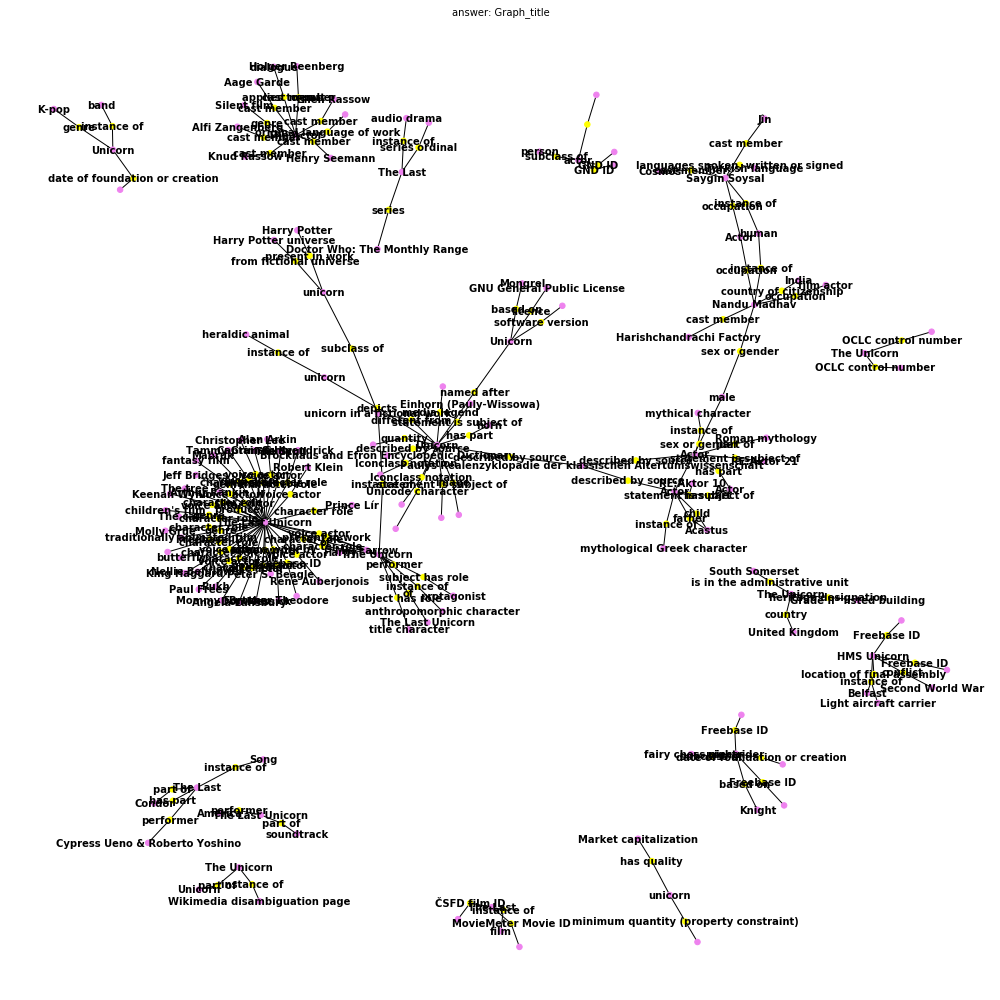

In [988]:
plot_graph(graph_2, "test_file_name_graph", "Graph_title")

In [ ]:
#nlp_lookup_test = get_nlp("klein yves")
#[y['name'] for x,y in graph.nodes(data=True) if get_nlp(y['name']).similarity(nlp_lookup_test) >= 0.9]
[y['name'] for x,y in graph_2.nodes(data=True) if y['type'] == 'predicate']